<a href="https://colab.research.google.com/github/AggelosAr/MDS-of-Comment-Pools-with-Transformers/blob/main/thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INFO

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Oct  7 14:37:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# PIP installs dependencies

In [ ]:
!pip install datasets
!pip install transformers
!pip install rouge_score
!pip install evaluate
!pip install bert_score
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 14.1 MB/s 
     |████████████████████████████████| 101 kB 10.6 MB/s 
     |████████████████████████████████| 141 kB 63.2 MB/s 
     |████████████████████████████████| 212 kB 65.4 MB/s 
     |████████████████████████████████| 596 kB 57.8 MB/s 
     |████████████████████████████████| 127 kB 58.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 w

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import train_test_split

import csv
import json
import nltk
import os
import datasets
import transformers
import time
import textwrap


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from datasets import Dataset, load_metric
from evaluate import load
from keras.callbacks import ModelCheckpoint

from transformers.keras_callbacks import KerasMetricCallback
from transformers import TFBartForConditionalGeneration, BartTokenizer, BartForConditionalGeneration
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForSeq2Seq
from transformers import create_optimizer, AdamWeightDecay
from transformers import LongT5ForConditionalGeneration, AutoTokenizer

from transformers import TFT5ForConditionalGeneration, T5Tokenizer

print(tf.__version__)
print(transformers.__version__)

nltk.download('punkt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2.8.2
4.21.0


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Functions for plots


In [ ]:
def print_plots(model_name, metrics, params):
    plt.rcParams["figure.figsize"] = params
    
    curr_path = "/content/drive/MyDrive/best_weights/histories/"
    emails_path  = curr_path+str(model_name)+"/"+str(model_name)+"_emails_history"
    nyt_path  = curr_path+str(model_name)+"/"+str(model_name)+"_nyt_history"
    reddit_path  = curr_path+str(model_name)+"/"+str(model_name)+"_reddit_history"
    stack_path  = curr_path+str(model_name)+"/"+str(model_name)+"_stack_history"
    convoSum_path  = curr_path+str(model_name)+"/"+str(model_name)+"_convoSum_history"

    emails_history = json.load(open(emails_path, 'r'))
    nyt_history = json.load(open(nyt_path, 'r'))
    reddit_history = json.load(open(reddit_path, 'r'))

    stack_history = json.load(open(stack_path, 'r'))
    convoSum_history = json.load(open(convoSum_path, 'r'))
    
    fig = plt.figure()
    fig.suptitle(model_name, fontsize=15)

    j = 1
    for metric in metrics:
      plt.subplot(1, len(metrics), j)
      j+=1

      plt.plot(emails_history[metric])
      plt.plot(nyt_history[metric])
      plt.plot(reddit_history[metric])

      plt.plot(stack_history[metric])
      plt.plot(convoSum_history[metric], '--')
      
      
      plt.title(metric)
      plt.ylabel('value')
      plt.xlabel('epoch')
      
      plt.legend(['emails', 'nyt', 'reddit', 'stack', 'convoSum'], loc='best')
      
      #plt.show()

    
    
def preprocess_function_BART_tokenizer_SHOW_TOKENS_LENS(examples):
    
    inputs = [doc for doc in examples["text"]]
    model_inputs = tok_BART(inputs)
    with tok_BART.as_target_tokenizer():
        labels = tok_BART(examples["summary"])
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs   

def plot_distribution(data, name, params = (15, 3)):
    plt.rcParams["figure.figsize"] = params
    fig = plt.figure()
    fig.suptitle(name, fontsize=15)
    
    
    plt.subplot(1, 2, 1)
    plt.xlabel('Samples')
    plt.ylabel('Tokens')
    plt.plot(data)
    plt.title('Tokens per Text sample.')
    
    
    plt.subplot(1, 2, 2)
    n, bins, patches = plt.hist(x=data, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Distribution')
    


def plot_all(path):
  history = json.load(open(history_path, 'r'))
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('Train')
  plt.ylabel('value')
  plt.xlabel('epoch')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  plt.show()

  plt.rcParams["figure.figsize"] = (15,5)
  try :
    plt.subplot(1, 3, 1)
    plt.title('ROUGE-1')
    plt.plot(history['rouge1'])
    plt.ylabel('value')
    plt.xlabel('epoch')

    plt.subplot(1, 3, 2)
    plt.title('ROUGE-2')
    plt.plot(history['rouge2'])
    plt.ylabel('value')
    plt.xlabel('epoch')

    plt.subplot(1, 3, 3)
    plt.title('ROUGE-L')
    plt.plot(history['rougeL'])
    plt.ylabel('value')
    plt.xlabel('epoch')

    plt.show()
  except:
    pass

# Helpful functions

In [ ]:

# Iterate the files and get only the source and target files .
def gather_parts(part_name):

    dataset = {}

    # Iterate the files and get only the source and target files .
    for file in os.listdir( '/content/drive/MyDrive/4datasets/'+str(part_name)+'/arg-filtered'):
        if file in ['test.source', 'test.target', 'train.source', 'train.target', 'val.source', 'val.target']:
            with open( '/content/drive/MyDrive/4datasets/'+str(part_name)+'/arg-filtered/'+str(file), encoding="utf8") as posts:
                dataset[file] = [post for post in posts]

    return dataset

# Returns the train eval test splits of the dataset part given as an argument.
def preprocess_function_step_1(part_name_asked):
    
    dataset = {
        "test.source" : [],
        "test.target" : [],
        "train.source" : [],
        "train.target" : [],
        "val.source" : [], 
        "val.target" : []
    }

    if part_name_asked is None:
      all_parts = ["email", "nyt", "reddit", "stack"]
    else:
      all_parts = [part_name_asked]

    for part_name in all_parts:
        temp_dataset = gather_parts(part_name)
        dataset["test.source"] += temp_dataset["test.source"]
        dataset["test.target"] += temp_dataset["test.target"]
        dataset["train.source"] += temp_dataset["train.source"]
        dataset["train.target"] += temp_dataset["train.target"]
        dataset["val.source"] += temp_dataset["val.source"]
        dataset["val.target"] += temp_dataset["val.target"]
        
    source = []
    summaries = []
    # Since in the folder all data are in seperate files, they are merged in only 2 lists , the source text and the summary.
    for part in dataset.keys():
        if "source" in part:
            source += dataset[part]
        elif "target" in part:
            summaries += dataset[part]
    # Next step is to filter the entries that when tokenized would result in more than 1024 tokens. 
    # Here we can use truncate = True so that we won't discard any entries.
    #source_filtered, summaries_filtered = tokenize_data(source, summaries, tok_model)
    
    # We create a dataframe with the text and the summary.
    pairs = {  'text': source,
                'summary': summaries
            }
    pairs = pd.DataFrame(pairs)

    # Next we load the pandas dataframe into the dataset Class
    pairs = Dataset.from_pandas(pairs)

    # Split them into train, eval and test in a 70 20 10 ratio. for train / eval / test
    pairs = pairs.train_test_split(test_size=0.1, shuffle = False)
    train = pairs["train"]
    test = pairs["test"]
    train_eval = train.train_test_split(test_size=0.22, shuffle = False)

    # Since we used the train test split method 2 times the name of the 2 keys in the dictionary are by default
    # "train" and "test" so for sanity check we rename it to eval .
    train_eval["validation"] = train_eval.pop("test")
    train_eval["test"] = test

    return train_eval
    

def preprocess_function_BART_tokenizer(examples):
    
    inputs = [doc for doc in examples["text"]]
    model_inputs = tok_BART(inputs, truncation=True, padding="max_length", max_length = 1024)
    with tok_BART.as_target_tokenizer():
        labels = tok_BART(examples["summary"], truncation=True, padding="max_length", max_length = 128)
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs   

def preprocess_function_BART_tokenizer_512_tokens(examples):
    
    inputs = [doc for doc in examples["text"]]
    model_inputs = tok_BART(inputs, truncation=True, padding="max_length", max_length = 512)
    with tok_BART.as_target_tokenizer():
        labels = tok_BART(examples["summary"], truncation=True, padding="max_length", max_length = 128)
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs 

def preprocess_function_PEGASUS_tokenizer(examples):
    
    inputs = [doc for doc in examples["text"]]
    model_inputs = tok_PEGASUS(inputs, truncation=True, padding="max_length", max_length = 512)
    with tok_PEGASUS.as_target_tokenizer():
        labels = tok_PEGASUS(examples["summary"], truncation=True, padding="max_length", max_length = 128)
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs 

def preprocess_function_T5_tokenizer(examples):
    prefix = "summarize: "
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tok_T5(inputs, truncation=True, padding="max_length", max_length = 512)
    with tok_T5.as_target_tokenizer():
        labels = tok_T5(examples["summary"], truncation=True, padding="max_length", max_length = 128)
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs 



def get_tf_dataset_iterator(dataset, batch_sizes):
  # Convert the dataset to the tf.data.Dataset format 
  tf_train_set = dataset["train"].to_tf_dataset(
      columns=["input_ids", "attention_mask", "labels"],
      shuffle=True,
      batch_size=batch_sizes,
      collate_fn=data_collator,
  )
  tf_val_set = dataset["validation"].to_tf_dataset(
      columns=["input_ids", "attention_mask", "labels"],
      shuffle=False,
      batch_size=batch_sizes,
      collate_fn=data_collator,
  )
  tf_test_set = dataset["test"].to_tf_dataset(
      columns=["input_ids", "attention_mask", "labels"],
      shuffle=False,
      batch_size=batch_sizes,
      collate_fn=data_collator,
  )
  generation_dataset = (
    dataset["validation"]
    .shuffle()
    .select(list(range(20)))
    .to_tf_dataset(
        batch_size=8,
        columns=["input_ids", "attention_mask", "labels"],
        shuffle=False,
        collate_fn=data_collator,
    )
)


  return tf_train_set, tf_val_set, tf_test_set, generation_dataset


def compute_metrics(inputs, gold_summaries, model, tokenizer, name):
    summary_ids = model.generate(inputs, num_beams=4, max_length = 128, min_length = 100)
    #if name == "BART":
    #  summary_ids = model.generate(inputs, num_beams=4, max_length = 125, min_length = 100)
    #if name == "PEGASUS":
    #  summary_ids = model.generate(inputs, max_length = 125, min_length = 100)
    #if name == "T5":#!!!!!!!!!!!!!!
    #  summary_ids = model.generate(inputs, max_length = 115, min_length = 100)
    decoded_preds = tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(gold_summaries != -100, gold_summaries, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    gold_summaries = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    result_rouge = metric.compute(predictions=decoded_preds, references=gold_summaries, use_stemmer=True)

    # Extract a few results
    result_rouge = {key: value.mid.fmeasure * 100 for key, value in result_rouge.items()}

    results_bertscore = bertscore.compute(predictions=decoded_preds, references=gold_summaries, lang="en")
    
    del results_bertscore["hashcode"]
    results_bertscore = {key: (sum(value)/len(value))*100 for key, value in results_bertscore.items()}

    return {k: round(v, 4) for k, v in result_rouge.items()}, {k: round(v, 4) for k, v in results_bertscore.items()}

# Evaluation function to test ROUGE and BERT score on the test set.
def show_metrics_nice(tokenized_dataset, model_name, tokenizer_name, batch_size, name ):

  inputs = np.squeeze(np.array([tokenized_dataset["test"]["input_ids"]]))
  gold_summaries = np.squeeze(np.array([tokenized_dataset["test"]["labels"]]))

  rouge_scores = []
  bert_scores = []

  for i in range(0, len(gold_summaries), batch_size):
    
    start = i
    end = batch_size + start
    if end > len(gold_summaries):
      end = len(gold_summaries)

    # Won't calculate 1~2 samples whith this if condition. with batch_size = 10
    if end - start == batch_size:
      rouge_a, bert_score_a = compute_metrics(inputs[start:end], gold_summaries[start:end], model_name, tokenizer_name, name)
      print(" CURRENT BATCH IS : ", start, end)
      print("ROUGE        :  ", rouge_a)
      print("BERT scores  :  ", bert_score_a)
      print("____________________________________________")
      rouge_scores.append(rouge_a)
      bert_scores.append(bert_score_a)
    else:
      print(" Discarded ", end - start, "sample/s")

  return rouge_scores, bert_scores


#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def metric_fn_BART(eval_predictions):
    predictions, labels = eval_predictions
    decoded_predictions = tok_BART.batch_decode(predictions, skip_special_tokens=True)
    for label in labels:
        label[label < 0] = tok_BART.pad_token_id  # Replace masked label tokens
    decoded_labels = tok_BART.batch_decode(labels, skip_special_tokens=True)
    # Rouge expects a newline after each sentence
    decoded_predictions = [
        "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
    ]
    decoded_labels = [
        "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
    ]
    result = metric.compute(
        predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
    )
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    # Add mean generated length
    prediction_lens = [
        np.count_nonzero(pred != tok_BART.pad_token_id) for pred in predictions
    ]
    result["gen_len"] = np.mean(prediction_lens)

    return result

def metric_fn_PEGASUS(eval_predictions):
    predictions, labels = eval_predictions
    decoded_predictions = tok_PEGASUS.batch_decode(predictions, skip_special_tokens=True)
    for label in labels:
        label[label < 0] = tok_PEGASUS.pad_token_id  # Replace masked label tokens
    decoded_labels = tok_PEGASUS.batch_decode(labels, skip_special_tokens=True)
    # Rouge expects a newline after each sentence
    decoded_predictions = [
        "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
    ]
    decoded_labels = [
        "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
    ]
    result = metric.compute(
        predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
    )
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    # Add mean generated length
    prediction_lens = [
        np.count_nonzero(pred != tok_PEGASUS.pad_token_id) for pred in predictions
    ]
    result["gen_len"] = np.mean(prediction_lens)

    return result

def metric_fn_T5(eval_predictions):
    predictions, labels = eval_predictions
    decoded_predictions = tok_T5.batch_decode(predictions, skip_special_tokens=True)
    for label in labels:
        label[label < 0] = tok_T5.pad_token_id  # Replace masked label tokens
    decoded_labels = tok_T5.batch_decode(labels, skip_special_tokens=True)
    # Rouge expects a newline after each sentence
    decoded_predictions = [
        "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
    ]
    decoded_labels = [
        "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
    ]
    result = metric.compute(
        predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
    )
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    # Add mean generated length
    prediction_lens = [
        np.count_nonzero(pred != tok_T5.pad_token_id) for pred in predictions
    ]
    result["gen_len"] = np.mean(prediction_lens)

    return result

def mean_scores(rouge_scores, bert_scores):
  rouge_1 = 0
  rouge_2 = 0
  rouge_L = 0
  rouge_Lsum = 0
  f1 = 0
  precision = 0
  recall = 0
  for i in range(len(rouge_scores)):
      rouge_1 += rouge_scores[i]["rouge1"]
      rouge_2 += rouge_scores[i]["rouge2"]
      rouge_L += rouge_scores[i]["rougeL"]
      rouge_Lsum += rouge_scores[i]["rougeLsum"]
  for i in range(len(bert_scores)):
      f1 += bert_scores[i]["f1"]
      precision += bert_scores[i]["precision"]
      recall += bert_scores[i]["recall"]

  rouge_1 = round(rouge_1/len(rouge_scores),3)
  rouge_2 = round(rouge_2/len(rouge_scores),3)
  rouge_L = round(rouge_L/len(rouge_scores),3)
  rouge_Lsum = round(rouge_Lsum/len(rouge_scores),3)
  f1 = round(f1/len(bert_scores),3)
  precision = round(precision/len(bert_scores),3)
  recall = round(recall/len(bert_scores),3)

  print("         ROUGE                          BERT SCORE\n")
  print("rouge-1    : ", rouge_1, return_space(20, rouge_1)*" ", "f1:", f1)
  print("rouge-2    : ", rouge_2, return_space(20, rouge_2)*" ", "precision:", precision)
  print("rouge-L    : ", rouge_L, return_space(20, rouge_L)*" ", "recall:", recall)
  print("rouge-Lsum : ", rouge_Lsum)

def return_space(num, temp):
  return num-len(str(temp))



def get_potential_models(history_path):
  history = json.load(open(history_path, 'r'))
  # min val_loss
  index = history["val_loss"].index(min(history["val_loss"]))
  print("LOWEST VAL_LOSS at epoch :", index+1, " -- loss : ", history["loss"][index], "val_loss : ", history["val_loss"][index], 
        "ROUGE-1 : ", history["rouge1"][index], "ROUGE-2 : ", 
        history["rouge2"][index], "ROUGE-L", history["rougeL"][index])
  # max ROUGE-1
  index = history["rouge1"].index(max(history["rouge1"]))
  print("BIGGEST ROUGE-1 at epoch :", index+1, " -- loss : ", history["loss"][index], "val_loss : ", history["val_loss"][index], 
        "ROUGE-1 : ", history["rouge1"][index], "ROUGE-2 : ", 
        history["rouge2"][index], "ROUGE-L", history["rougeL"][index])
  # max ROUGE-2
  index = history["rouge2"].index(max(history["rouge2"]))
  print("BIGGEST ROUGE-2 at epoch :", index+1, " -- loss : ", history["loss"][index], "val_loss : ", history["val_loss"][index], 
        "ROUGE-1 : ", history["rouge1"][index], "ROUGE-2 : ", 
        history["rouge2"][index], "ROUGE-L", history["rougeL"][index])
  #max ROUGE-L
  index = history["rougeL"].index(max(history["rougeL"]))
  print("BIGGEST ROUGE-L at epoch :", index+1, " -- loss : ", history["loss"][index], "val_loss : ", history["val_loss"][index], 
        "ROUGE-1 : ", history["rouge1"][index], "ROUGE-2 : ", 
        history["rouge2"][index], "ROUGE-L", history["rougeL"][index])
  

def show_gen_summaries(mod, tok, tokenized_data, min_len , shape, start_interval, end_interval):
  inputs = np.squeeze(np.array([tokenized_data["test"]["input_ids"]]))
  summas = tokenized_data["test"]["summary"]
  gold_summaries = np.squeeze(np.array([tokenized_data["test"]["labels"]]))

  results = []
  for i in range(start_interval, end_interval):#range(10,len(inputs)):
    decoded_labels = tok.batch_decode(gold_summaries[i], skip_special_tokens=True)
    #print("\nORIGINAL\n")
    #print(textwrap.fill(summas[i], 100))
    summary_ids = mod.generate(inputs[i].reshape(1,shape), num_beams=4, max_length = 125, min_length = min_len)
    decoded_preds = tok.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    #print("\nGENERATED\n")
    #print(textwrap.fill(decoded_preds[0], 100))
    #print("______________________________________________________________________________________________________")
    
    results.append([summas[i], decoded_preds[0]])
    

    #if i  == 12:
    #  break
  return results



def read_csv(path):
    
    file = open(path, encoding="utf8")
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    print("HEADER : ", header)
    rows = []
    for row in csvreader:
            rows.append(row)
    file.close()
    return rows

def tokenize_splits(txt_list):
    tokenized_list = []
    idx = 0

    while idx < len(txt_list)-1:

        temp_text = ""
        tok = {"input_ids" : []}

        start = idx

        while len(tok["input_ids"]) <= 1024:
            try:
                temp_text += txt_list[idx]
                tok = tok_BART(temp_text)
                idx += 1
            except IndexError:
                break

        if len(tok["input_ids"]) > 1024:
            idx -= 1
        end = idx

        list_to_string = "".join(txt_list[start:end])
        tok = tok_BART(list_to_string)

        #tokenized_list.append([[start, end], tok["input_ids"]]) 
        tokenized_list.append(tok["input_ids"]) 

    
    print(end == len(txt_list))
    

    print("MIN len of tokens : ", 
          min([len(tokenized_list[i]) for i in range(len(tokenized_list))]), 
          " -- MAX len of tokens : ", 
          max([len(tokenized_list[i]) for i in range(len(tokenized_list))]), 
         "-- Total chunks :", len(tokenized_list))
    
    plot_distribution([len(tokenized_list[i]) for i in range(len(tokenized_list))], "")
    
    return tokenized_list

def generate_splits(tokenized_list):
    generated_list = []
    for el in tokenized_list:
        
        min_arg = int((len(el)/1024)*100)
        max_arg = int((len(el)/1024)*125)

        temp = np.array(el)
        temp = temp.reshape(1, len(temp))

        summary_ids = model_BART.generate(temp, num_beams=4, 
                                          min_length = min_arg, max_length = max_arg )
        decoded_preds = tok_BART.batch_decode(summary_ids, 
                                              skip_special_tokens=True, 
                                              clean_up_tokenization_spaces=False)
        generated_list.append(decoded_preds)
    return generated_list


    

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Initializing distil-BART

In [ ]:
model_checkpoint = "sshleifer/distilbart-xsum-12-6"

model_BART = TFBartForConditionalGeneration.from_pretrained(model_checkpoint, from_pt=True )
tok_BART = AutoTokenizer.from_pretrained(model_checkpoint)

# Use DataCollatorForSeq2Seq to create a batch of examples
data_collator = DataCollatorForSeq2Seq(tokenizer=tok_BART, model=model_BART, return_tensors="tf")

metric = load_metric('rouge')
bertscore = load("bertscore")

# Set up an optimizer function.          
optimizer = AdamWeightDecay(learning_rate=4e-5, weight_decay_rate=0.01)

model_BART.compile(optimizer=optimizer)
model_BART.summary()

# E-mails subset with BART

In [ ]:
emails = preprocess_function_step_1("email")
tokenized_emails = emails.map(preprocess_function_BART_tokenizer, batched=True)
emails_train_set, emails_val_set, emails_test_set, emails_generation = get_tf_dataset_iterator(tokenized_emails, batch_sizes = 4)

filepath = "/content/drive/MyDrive/best_weights/BART_emails/saved-model-{epoch:02d}"
history_path = "/content/drive/MyDrive/best_weights/BART_emails_history"

checkpoint = ModelCheckpoint(filepath,  verbose=1, save_weights_only = True, save_freq='epoch')

metric_callback = KerasMetricCallback(
    metric_fn_BART, eval_dataset=emails_generation, predict_with_generate=True
)

Parameter 'function'=<function preprocess_function_BART_tokenizer at 0x7f06c60e2560> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
callbacks_list = [metric_callback, checkpoint]

with tf.device('/GPU:0'):
    history_emails = model_BART.fit(x = emails_train_set, validation_data = emails_val_set, epochs=5, callbacks=callbacks_list)

json.dump(history_emails.history, open(history_path, 'w'))

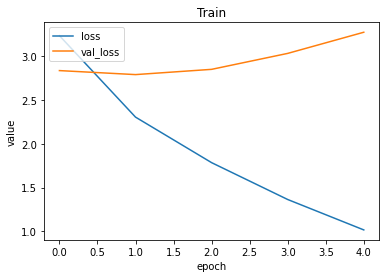

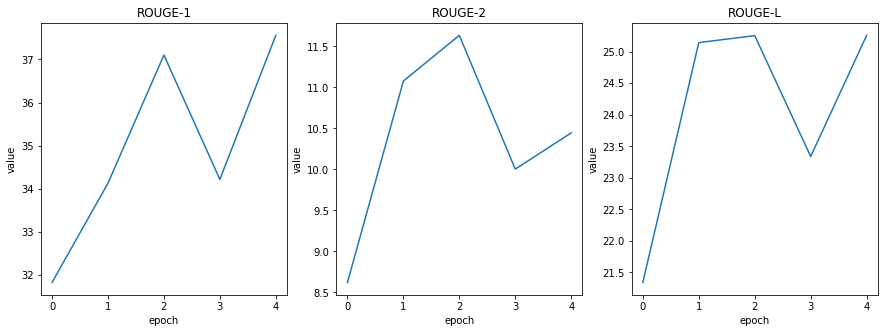

LOWEST VAL_LOSS at epoch : 2  -- loss :  2.30642032623291 val_loss :  2.792294979095459 ROUGE-1 :  34.12393273874198 ROUGE-2 :  11.077248108246437 ROUGE-L 25.145401931796364
BIGGEST ROUGE-1 at epoch : 5  -- loss :  1.016841173171997 val_loss :  3.276541233062744 ROUGE-1 :  37.56044614971636 ROUGE-2 :  10.444901040627414 ROUGE-L 25.260650992351096
BIGGEST ROUGE-2 at epoch : 3  -- loss :  1.785823106765747 val_loss :  2.852402448654175 ROUGE-1 :  37.103053006007904 ROUGE-2 :  11.634604688970796 ROUGE-L 25.256866717006645
BIGGEST ROUGE-L at epoch : 5  -- loss :  1.016841173171997 val_loss :  3.276541233062744 ROUGE-1 :  37.56044614971636 ROUGE-2 :  10.444901040627414 ROUGE-L 25.260650992351096


In [ ]:
history_path = "/content/drive/MyDrive/best_weights/BART_emails_history"
plot_all(history_path)
get_potential_models(history_path)

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/BART_emails/saved-model-02"
model_BART.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_emails, model_BART, tok_BART, batch_size = 5, name = "BART") 
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 42.4841, 'rouge2': 15.3548, 'rougeL': 27.8388, 'rougeLsum': 38.1851}
BERT scores  :   {'precision': 89.536, 'recall': 87.4067, 'f1': 88.45}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 37.8963, 'rouge2': 8.8672, 'rougeL': 23.0661, 'rougeLsum': 30.9085}
BERT scores  :   {'precision': 86.416, 'recall': 86.0486, 'f1': 86.2267}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 37.7801, 'rouge2': 11.0104, 'rougeL': 25.7031, 'rougeLsum': 35.9617}
BERT scores  :   {'precision': 86.9148, 'recall': 86.642, 'f1': 86.7767}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 42.5183, 'rouge2': 16.5972, 'rougeL': 28.2988, 'rougeLsum': 40.1384}
BERT scores  :   {'precision': 89.2349, 'recall': 88.5604, 'f1': 88.8908}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE     

In [ ]:
inputs = np.squeeze(np.array([tokenized_emails["test"]["input_ids"]]))
summas = tokenized_emails["test"]["summary"]
gold_summaries = np.squeeze(np.array([tokenized_emails["test"]["labels"]]))
tok = tok_BART
mod = model_BART
for i in range(10,len(inputs)):
  decoded_labels = tok.batch_decode(gold_summaries[i], skip_special_tokens=True)
  print("\nORIGINAL\n")
  print(textwrap.fill(summas[i], 100))
  summary_ids = mod.generate(inputs[i].reshape(1,1024), num_beams=4, max_length = 125, min_length = 100)
  decoded_preds = tok.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
  print("\nGENERATED\n")
  print(textwrap.fill(decoded_preds[0], 100))
  print("______________________________________________________________________________________________________")
  if i  == 14:
    break


ORIGINAL

Martin states that the Snapshots with both diff markup and the change logs are now available. He
also states that these are the URLs that are members only and currently have an error in the Table
of Contents that have 'strange characters.'  Martin states that other parts are now available, and
the TOC errors have been corrected.

GENERATED

Martin Gudgin says that the editors have prepared PR snapshots of parts 0, 1 and 2. Martin Gudge
says that TOCs are fixed and that the TOC problem will be fixed soon. Gudge also says that parts of
1, 1, and 2 suffer from the strange characters in TOC and that some parts are now available without
diff markup. Martin and Gudge say that it is a good idea to start with a PR snapshot for parts 0[0,
1[1, 1.
______________________________________________________________________________________________________

ORIGINAL

Michael states his case for no longer supporting the ordering or differences of time values, arguing
that the user should state

# Nyt subset with BART

In [ ]:
nyt = preprocess_function_step_1("nyt")
tokenized_nyt = nyt.map(preprocess_function_BART_tokenizer, batched=True)
nyt_train_set, nyt_val_set, nyt_test_set, nyt_generation = get_tf_dataset_iterator(tokenized_nyt, batch_sizes = 4)

filepath = "/content/drive/MyDrive/best_weights/BART_nyt/saved-model-{epoch:02d}"
history_path = "/content/drive/MyDrive/best_weights/BART_nyt_history"

checkpoint = ModelCheckpoint(filepath,  verbose=1, save_weights_only = True, save_freq='epoch')

metric_callback = KerasMetricCallback(
    metric_fn_BART, eval_dataset=nyt_generation, predict_with_generate=True
)

Parameter 'function'=<function preprocess_function_BART_tokenizer at 0x7f92b4859320> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
callbacks_list = [metric_callback, checkpoint]

with tf.device('/GPU:0'):
    history_nyt = model_BART.fit(x = nyt_train_set, validation_data = nyt_val_set, epochs=5, callbacks=callbacks_list) 

json.dump(history_nyt.history, open(history_path, 'w'))

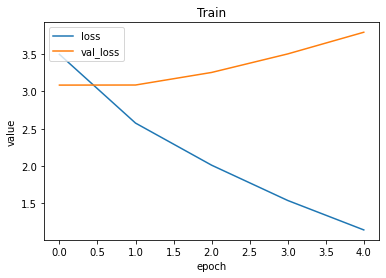

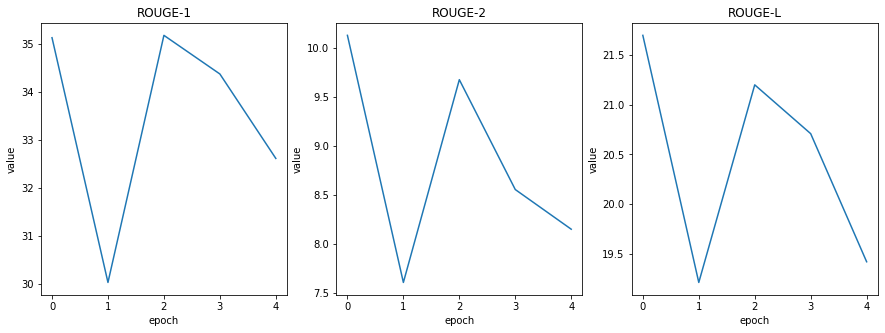

LOWEST VAL_LOSS at epoch : 1  -- loss :  3.498476028442383 val_loss :  3.085528612136841 ROUGE-1 :  35.130576194772296 ROUGE-2 :  10.123981146901025 ROUGE-L 21.69432862899044
BIGGEST ROUGE-1 at epoch : 3  -- loss :  2.0101683139801025 val_loss :  3.2554075717926025 ROUGE-1 :  35.179704096879085 ROUGE-2 :  9.67253479777788 ROUGE-L 21.19749430463809
BIGGEST ROUGE-2 at epoch : 1  -- loss :  3.498476028442383 val_loss :  3.085528612136841 ROUGE-1 :  35.130576194772296 ROUGE-2 :  10.123981146901025 ROUGE-L 21.69432862899044
BIGGEST ROUGE-L at epoch : 1  -- loss :  3.498476028442383 val_loss :  3.085528612136841 ROUGE-1 :  35.130576194772296 ROUGE-2 :  10.123981146901025 ROUGE-L 21.69432862899044


In [ ]:
history_path = "/content/drive/MyDrive/best_weights/BART_nyt_history"
plot_all(history_path)
get_potential_models(history_path)

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/BART_nyt/saved-model-01"
model_BART.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_nyt, model_BART, tok_BART, batch_size = 5, name = "BART") 
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 37.1219, 'rouge2': 9.5322, 'rougeL': 22.5055, 'rougeLsum': 33.9514}
BERT scores  :   {'precision': 87.8422, 'recall': 87.6623, 'f1': 87.7502}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 38.7664, 'rouge2': 12.0953, 'rougeL': 22.4687, 'rougeLsum': 33.6686}
BERT scores  :   {'precision': 88.4818, 'recall': 88.5071, 'f1': 88.4906}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 36.4667, 'rouge2': 10.3295, 'rougeL': 22.5178, 'rougeLsum': 32.8387}
BERT scores  :   {'precision': 87.9153, 'recall': 87.1614, 'f1': 87.5367}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 33.4463, 'rouge2': 8.5833, 'rougeL': 24.609, 'rougeLsum': 30.6726}
BERT scores  :   {'precision': 87.8195, 'recall': 87.3713, 'f1': 87.5939}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE  

In [ ]:
tok = tok_BART
mod = model_BART
tokenized_data = tokenized_nyt

inputs = np.squeeze(np.array([tokenized_data["test"]["input_ids"]]))
summas = tokenized_data["test"]["summary"]
gold_summaries = np.squeeze(np.array([tokenized_data["test"]["labels"]]))

for i in range(10,len(inputs)):
  decoded_labels = tok.batch_decode(gold_summaries[i], skip_special_tokens=True)
  print("\nORIGINAL\n")
  print(textwrap.fill(summas[i], 100))
  summary_ids = mod.generate(inputs[i].reshape(1,1024), num_beams=4, max_length = 125, min_length = 100)
  decoded_preds = tok.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
  print("\nGENERATED\n")
  print(textwrap.fill(decoded_preds[0], 100))
  print("______________________________________________________________________________________________________")
  if i  == 14:
    break


ORIGINAL

Several of the commenters talk about their long histories as Cub fans and how nice it was to see the
cubs play in the World Series, often talking about past family members who also would have loved to
have seen it. Others are critical of the announcers, ESPN, and Cubs fans. The user critical of ESPN
says that they "own" baseball and that they have too much power over things such as requiring there
be night games.

GENERATED

Many of the commenters talk about their experiences with Wrigley Field and the game itself. One
commenter says that the Cubs are the best team in baseball. Another commenter says the game was
boring, but that the game wasn't as bad as it was long ago and that it was boring. Another
commentator says that they were disappointed with the way the game went on and that the team was
played in the dark. Another comment says that it wasn't good enough to be a good game.
_____________________________________________________________________________________________

# Reddit subset with BART

In [ ]:
reddit = preprocess_function_step_1("reddit")
tokenized_reddit = reddit.map(preprocess_function_BART_tokenizer, batched=True)
reddit_train_set, reddit_val_set, reddit_test_set, reddit_generation = get_tf_dataset_iterator(tokenized_reddit, batch_sizes = 4)

filepath = "/content/drive/MyDrive/best_weights/BART_reddit/saved-model-{epoch:02d}"
history_path = "/content/drive/MyDrive/best_weights/BART_reddit_history"

checkpoint = ModelCheckpoint(filepath,  verbose=1, save_weights_only = True, save_freq='epoch')

metric_callback = KerasMetricCallback(
    metric_fn_BART, eval_dataset=reddit_generation, predict_with_generate=True
)

Parameter 'function'=<function preprocess_function_BART_tokenizer at 0x7f44d8a2a7a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
callbacks_list = [metric_callback, checkpoint]

with tf.device('/GPU:0'):
    history_reddit = model_BART.fit(x = reddit_train_set, validation_data = reddit_val_set, epochs=3, callbacks=callbacks_list)

json.dump(history_reddit.history, open(history_path, 'w'))

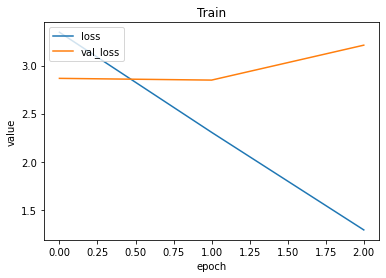

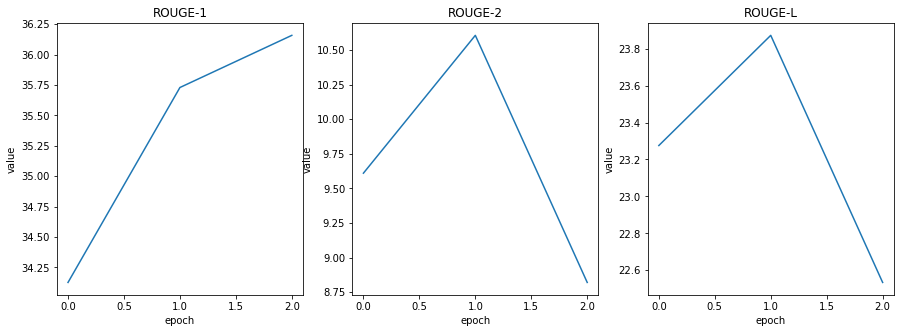

LOWEST VAL_LOSS at epoch : 2  -- loss :  2.3057 val_loss :  2.8486 ROUGE-1 :  35.7297 ROUGE-2 :  10.6062 ROUGE-L 23.8725
BIGGEST ROUGE-1 at epoch : 3  -- loss :  1.291 val_loss :  3.2117 ROUGE-1 :  36.1589 ROUGE-2 :  8.8208 ROUGE-L 22.5338
BIGGEST ROUGE-2 at epoch : 2  -- loss :  2.3057 val_loss :  2.8486 ROUGE-1 :  35.7297 ROUGE-2 :  10.6062 ROUGE-L 23.8725
BIGGEST ROUGE-L at epoch : 2  -- loss :  2.3057 val_loss :  2.8486 ROUGE-1 :  35.7297 ROUGE-2 :  10.6062 ROUGE-L 23.8725


In [ ]:
history_path = "/content/drive/MyDrive/best_weights/BART_reddit_history"
plot_all(history_path)
get_potential_models(history_path)

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/BART_reddit/saved-model-02"
model_BART.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_reddit, model_BART, tok_BART, batch_size = 5, name = "BART")  
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 37.3392, 'rouge2': 11.3602, 'rougeL': 24.5863, 'rougeLsum': 34.4311}
BERT scores  :   {'precision': 87.4109, 'recall': 87.4972, 'f1': 87.4525}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 39.6633, 'rouge2': 11.2495, 'rougeL': 21.369, 'rougeLsum': 34.9503}
BERT scores  :   {'precision': 87.4956, 'recall': 88.1965, 'f1': 87.8436}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 34.029, 'rouge2': 8.3328, 'rougeL': 20.2141, 'rougeLsum': 30.8495}
BERT scores  :   {'precision': 86.5804, 'recall': 88.2157, 'f1': 87.3837}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 35.718, 'rouge2': 13.621, 'rougeL': 25.2314, 'rougeLsum': 33.1456}
BERT scores  :   {'precision': 88.1579, 'recall': 89.0421, 'f1': 88.5937}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE    

In [ ]:
tok = tok_BART
mod = model_BART
tokenized_data = tokenized_reddit

inputs = np.squeeze(np.array([tokenized_data["test"]["input_ids"]]))
summas = tokenized_data["test"]["summary"]
gold_summaries = np.squeeze(np.array([tokenized_data["test"]["labels"]]))

for i in range(10,len(inputs)):
  decoded_labels = tok.batch_decode(gold_summaries[i], skip_special_tokens=True)
  print("\nORIGINAL\n")
  print(textwrap.fill(summas[i], 100))
  summary_ids = mod.generate(inputs[i].reshape(1,1024), num_beams=4, max_length = 125, min_length = 100)
  decoded_preds = tok.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
  print("\nGENERATED\n")
  print(textwrap.fill(decoded_preds[0], 100))
  print("______________________________________________________________________________________________________")
  if i  == 14:
    break


ORIGINAL

Some commenters say that one has to pay to change their name. One commenter includes a link to
origin.com, which allows user to change their name. Another says that changing the username will
change the soldier name too. Another commenter adds that the change option is currently unavailable.

GENERATED

Most commenters agree that it will automatically rename your soldier name. A few commenters say that
you can change it through Xbox and ps3. One commenter says that it's only for PC. Another commenter
states that they paid Microsoft ten or fifteen dollars to change their gamertag. The original poster
says that they can do it by paying Microsoft ten dollars to do it. The commenter says it's not a
prob. One commentator says it’s only for Xbox and that they’ve done it through the origin username.
______________________________________________________________________________________________________

ORIGINAL

The commenters ask the poster questions, mainly about themself. One ask

# Stack subset with BART

In [ ]:
stack = preprocess_function_step_1("stack")
tokenized_stack = stack.map(preprocess_function_BART_tokenizer, batched=True)
stack_train_set, stack_val_set, stack_test_set, stack_generation = get_tf_dataset_iterator(tokenized_stack, batch_sizes = 4)

filepath = "/content/drive/MyDrive/best_weights/BART_stack/saved-model-{epoch:02d}"
history_path = "/content/drive/MyDrive/best_weights/BART_stack_history"

checkpoint = ModelCheckpoint(filepath,  verbose=1, save_weights_only = True, save_freq='epoch')

metric_callback = KerasMetricCallback(
    metric_fn_BART, eval_dataset=stack_generation, predict_with_generate=True
)

Parameter 'function'=<function preprocess_function_BART_tokenizer at 0x7ff9203ca560> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
callbacks_list = [metric_callback, checkpoint]

with tf.device('/GPU:0'):
    history_stack = model_BART.fit(x = stack_train_set, validation_data = stack_val_set, epochs=3, callbacks=callbacks_list) 

json.dump(history_stack.history, open(history_path, 'w'))

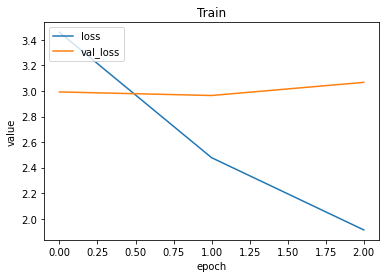

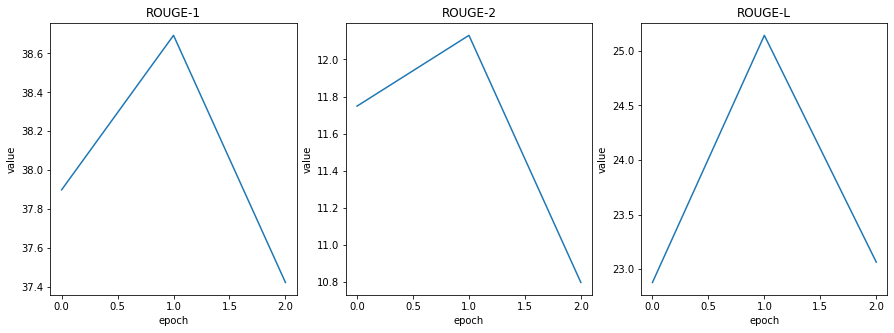

LOWEST VAL_LOSS at epoch : 2  -- loss :  2.477642774581909 val_loss :  2.9645373821258545 ROUGE-1 :  38.693003218886176 ROUGE-2 :  12.129687687864836 ROUGE-L 25.14183649933669
BIGGEST ROUGE-1 at epoch : 2  -- loss :  2.477642774581909 val_loss :  2.9645373821258545 ROUGE-1 :  38.693003218886176 ROUGE-2 :  12.129687687864836 ROUGE-L 25.14183649933669
BIGGEST ROUGE-2 at epoch : 2  -- loss :  2.477642774581909 val_loss :  2.9645373821258545 ROUGE-1 :  38.693003218886176 ROUGE-2 :  12.129687687864836 ROUGE-L 25.14183649933669
BIGGEST ROUGE-L at epoch : 2  -- loss :  2.477642774581909 val_loss :  2.9645373821258545 ROUGE-1 :  38.693003218886176 ROUGE-2 :  12.129687687864836 ROUGE-L 25.14183649933669


In [ ]:
history_path = "/content/drive/MyDrive/best_weights/BART_stack_history"
plot_all(history_path)
get_potential_models(history_path)

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/BART_stack/saved-model-02"
model_BART.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_stack, model_BART, tok_BART, batch_size = 5, name = "BART")  
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 34.3406, 'rouge2': 9.0666, 'rougeL': 21.6002, 'rougeLsum': 30.1566}
BERT scores  :   {'precision': 87.4639, 'recall': 87.5198, 'f1': 87.4893}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 39.4631, 'rouge2': 12.0902, 'rougeL': 25.0268, 'rougeLsum': 34.2091}
BERT scores  :   {'precision': 88.4103, 'recall': 87.9515, 'f1': 88.1787}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 38.9586, 'rouge2': 11.4485, 'rougeL': 21.4272, 'rougeLsum': 35.8931}
BERT scores  :   {'precision': 87.5611, 'recall': 87.434, 'f1': 87.4935}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 40.2588, 'rouge2': 13.1691, 'rougeL': 25.8784, 'rougeLsum': 33.9927}
BERT scores  :   {'precision': 87.9385, 'recall': 88.6599, 'f1': 88.2946}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE 

In [ ]:
tok = tok_BART
mod = model_BART
tokenized_data = tokenized_stack

inputs = np.squeeze(np.array([tokenized_data["test"]["input_ids"]]))
summas = tokenized_data["test"]["summary"]
gold_summaries = np.squeeze(np.array([tokenized_data["test"]["labels"]]))

for i in range(10,len(inputs)):
  decoded_labels = tok.batch_decode(gold_summaries[i], skip_special_tokens=True)
  print("\nORIGINAL\n")
  print(textwrap.fill(summas[i], 100))
  summary_ids = mod.generate(inputs[i].reshape(1,1024), num_beams=4, max_length = 125, min_length = 100)
  decoded_preds = tok.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
  print("\nGENERATED\n")
  print(textwrap.fill(decoded_preds[0], 100))
  print("______________________________________________________________________________________________________")
  if i  == 14:
    break


ORIGINAL

Many commentators give suggestions for a circuit, either to improve his current one or to give him a
new one. Several commentators say that the zeners are backward, but one says that they’re just fine.
One commentator recommends an opamp, and another gives a product link for an AC output.

GENERATED

Commenters agree that zeners can be reversed to make it work in principle. One commenter suggests
using a regulator to regulate the supply. Another suggests using an opamp instead of the 9-volt
battery. One commentator suggests a different topology to keep current from drawing current from the
power supply. Other suggestions are a power-opamp, a voltage regulator, and a virtual ground circuit
that will draw more current. One says that it will not work at low current levels.
______________________________________________________________________________________________________

ORIGINAL

Commentators are nearly unanimous that the Kansas City strip and New York strip are the same m

# Full dataset with BART

In [ ]:
convoSum = preprocess_function_step_1(None)
tokenized_convoSum = convoSum.map(preprocess_function_BART_tokenizer, batched=True)
convoSum_train_set, convoSum_val_set, convoSum_test_set, convoSum_generation= get_tf_dataset_iterator(tokenized_convoSum, batch_sizes = 4)

emails = preprocess_function_step_1("email")
tokenized_emails = emails.map(preprocess_function_BART_tokenizer, batched=True)

nyt = preprocess_function_step_1("nyt")
tokenized_nyt = nyt.map(preprocess_function_BART_tokenizer, batched=True)

reddit = preprocess_function_step_1("reddit")
tokenized_reddit = reddit.map(preprocess_function_BART_tokenizer, batched=True)

stack = preprocess_function_step_1("stack")
tokenized_stack = stack.map(preprocess_function_BART_tokenizer, batched=True)

filepath = "/content/drive/MyDrive/best_weights/BART_convoSum/saved-model-{epoch:02d}"
history_path = "/content/drive/MyDrive/best_weights/BART_convoSum_history"

checkpoint = ModelCheckpoint(filepath,  verbose=1, save_weights_only = True, save_freq='epoch')

metric_callback = KerasMetricCallback(
    metric_fn_BART, eval_dataset=convoSum_generation, predict_with_generate=True
)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
callbacks_list = [metric_callback, checkpoint]

with tf.device('/GPU:0'):
    history_convoSum = model_BART.fit(x = convoSum_train_set, validation_data = convoSum_val_set, epochs=2, callbacks=callbacks_list) 

json.dump(history_convoSum.history, open(history_path, 'w'))

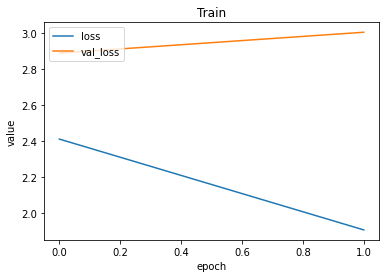

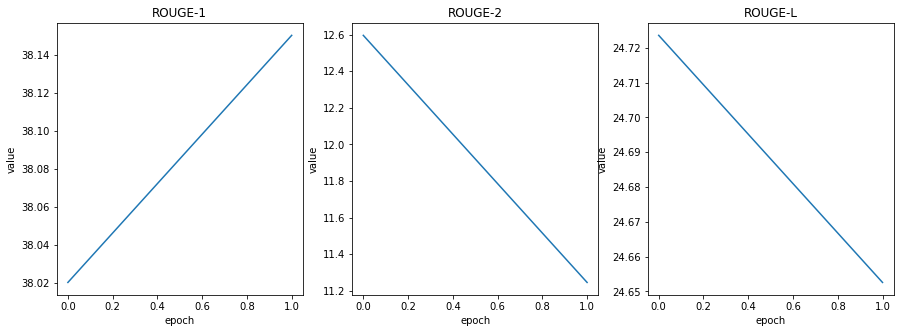

LOWEST VAL_LOSS at epoch : 1  -- loss :  2.412 val_loss :  2.889 ROUGE-1 :  38.0204 ROUGE-2 :  12.5955 ROUGE-L 24.7236
BIGGEST ROUGE-1 at epoch : 2  -- loss :  1.9084 val_loss :  3.0045 ROUGE-1 :  38.1501 ROUGE-2 :  11.2458 ROUGE-L 24.6526
BIGGEST ROUGE-2 at epoch : 1  -- loss :  2.412 val_loss :  2.889 ROUGE-1 :  38.0204 ROUGE-2 :  12.5955 ROUGE-L 24.7236
BIGGEST ROUGE-L at epoch : 1  -- loss :  2.412 val_loss :  2.889 ROUGE-1 :  38.0204 ROUGE-2 :  12.5955 ROUGE-L 24.7236


In [ ]:
history_path = "/content/drive/MyDrive/best_weights/BART_convoSum_history"
plot_all(history_path)
get_potential_models(history_path)

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/BART_convoSum/saved-model-01"
model_BART.load_weights(filepath)

In [ ]:
rouge_a, bert_a = show_metrics_nice(tokenized_emails, model_BART, tok_BART, batch_size = 5, name = "BART")
mean_scores(rouge_a, bert_a)

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 45.1062, 'rouge2': 16.9766, 'rougeL': 27.5295, 'rougeLsum': 42.4292}
BERT scores  :   {'precision': 89.3211, 'recall': 88.7514, 'f1': 89.035}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 37.5235, 'rouge2': 8.8505, 'rougeL': 21.9021, 'rougeLsum': 34.2355}
BERT scores  :   {'precision': 86.0866, 'recall': 86.5172, 'f1': 86.299}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 39.2487, 'rouge2': 11.216, 'rougeL': 25.012, 'rougeLsum': 36.5929}
BERT scores  :   {'precision': 87.0715, 'recall': 86.9633, 'f1': 87.0118}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 42.1905, 'rouge2': 13.8242, 'rougeL': 23.2559, 'rougeLsum': 37.5609}
BERT scores  :   {'precision': 87.7881, 'recall': 88.7013, 'f1': 88.2379}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE    

In [ ]:
a = show_gen_summaries(model_BART, tok_BART, tokenized_emails, min_len = 100 , shape = 1024, start_interval = 40, end_interval = 45)


In [ ]:
print(a)#0-5

[["Scott Luebking asks if he should give a demo of some of the keyboard navigation during one of the conference calls. Scott Luebking then tells Denis that it would be easy to set up the demo and says that it might be interesting to have Raman's Emacs-speak do the demo for fifteen minutes then have five minutes for questions. Then he tells Jon that an advantage of using telnet is that you do not have to have it installed on each computer and says that he isn't sending the password.\n", 'Scott Luebking asks if he can give a demo of some of the keyboard navigation in his prototype browser. He replies that it’s easy to set up, and that he can’t send out the password. He then asks if people can try it outside of the telecon. He asks if someone can use EmacSpeak for 15 minutes to demonstrate the functionality of the system. He also asks if the user can access the browser via telnet, and he replies that he’ll post a demo.\n'], ['Andre asks if DOM IDL definitions can be mapped to C++ abstract

In [ ]:
print(a)#40-45

[['Loretta laments that she won’t be able to make it to the weekly meeting. Maurizio likewise says that he won’t be able to attend. Gian also can’t make it to the meeting. Eugenia replies that he can’t make it to the call today.\n', 'Loretta Guarino Reid says that she won’t be able to attend a meeting at Beacon Technologies. Maurizio Vittoria and Eugenia Slaydon say that they will not be attending this week’s meeting. Gian says that he was unable to make the call because of a lack of time. He then states that he’ll not be available to attend the meeting. He also says that they’re not able to call the call today.\n'], ['Judy gives a draft for a reference card that’s business-card sized. Daniel thinks that the intro and close are too long, then gives some specific tips on how to do it, such as rewording a phrase and removing redundant words and sentences.\n', "Judy wants to know how to make a website accessible for people with disabilities. Daniel replies that the intro and closing parag

In [ ]:
show_gen_summaries(model_BART, tok_BART, tokenized_emails, min_len = 100 , shape = 1024)


ORIGINAL

Martin states that the Snapshots with both diff markup and the change logs are now available. He
also states that these are the URLs that are members only and currently have an error in the Table
of Contents that have 'strange characters.'  Martin states that other parts are now available, and
the TOC errors have been corrected.

GENERATED

Martin Gudgin says that the editors have prepared a PR snapshot of parts 0, 1, and 2. He then says
that there will be snapshots without diff markup. He says that TOCs are now fixed and that this will
be fixed soon. He also says that parts 0 and 1 do not have diff markup and that the TOC is now
fixed. He states that Tocs have been fixed and will fix the problem. Finally, Martin states that the
screenshots are now available.
______________________________________________________________________________________________________

ORIGINAL

Michael states his case for no longer supporting the ordering or differences of time values, arguing
that

In [ ]:
rouge_a, bert_a = show_metrics_nice(tokenized_nyt, model_BART, tok_BART, batch_size = 5, name = "BART")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 36.8548, 'rouge2': 9.5829, 'rougeL': 21.9526, 'rougeLsum': 33.1954}
BERT scores  :   {'precision': 87.6541, 'recall': 88.1173, 'f1': 87.8833}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 37.1956, 'rouge2': 11.5089, 'rougeL': 22.692, 'rougeLsum': 33.4993}
BERT scores  :   {'precision': 88.2268, 'recall': 88.5591, 'f1': 88.3862}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 38.3868, 'rouge2': 9.5044, 'rougeL': 21.9904, 'rougeLsum': 33.8429}
BERT scores  :   {'precision': 87.5941, 'recall': 87.4759, 'f1': 87.534}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 36.8867, 'rouge2': 11.3871, 'rougeL': 22.4019, 'rougeLsum': 33.7268}
BERT scores  :   {'precision': 88.0123, 'recall': 87.923, 'f1': 87.9672}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE    

In [ ]:
show_gen_summaries(model_BART, tok_BART, tokenized_nyt, min_len = 100 , shape = 1024)


ORIGINAL

Several of the commenters talk about their long histories as Cub fans and how nice it was to see the
cubs play in the World Series, often talking about past family members who also would have loved to
have seen it. Others are critical of the announcers, ESPN, and Cubs fans. The user critical of ESPN
says that they "own" baseball and that they have too much power over things such as requiring there
be night games.

GENERATED

Many of the commenters express their support for the Cubs, with one commenter saying that the team
is the best in baseball. One commenter says that they are disappointed with the team's lack of focus
and focus on players. Another commenter said that they had not been able to watch the game for a
long time because it had to rain. One other commenter says they are happy with the Cubs' World
Series win and that they have waited 108 years for the team to win. One of these commenters says
that it was a "brilliant" game."
______________________________________

In [ ]:
rouge_a, bert_a = show_metrics_nice(tokenized_reddit, model_BART, tok_BART, batch_size = 5, name = "BART")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 38.5554, 'rouge2': 11.1634, 'rougeL': 23.2724, 'rougeLsum': 35.0456}
BERT scores  :   {'precision': 88.2847, 'recall': 88.3367, 'f1': 88.3088}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 37.9734, 'rouge2': 10.0387, 'rougeL': 22.9867, 'rougeLsum': 35.6607}
BERT scores  :   {'precision': 87.9702, 'recall': 88.369, 'f1': 88.1671}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 36.2547, 'rouge2': 12.067, 'rougeL': 22.7522, 'rougeLsum': 33.0463}
BERT scores  :   {'precision': 87.4049, 'recall': 88.6277, 'f1': 88.0019}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 34.3774, 'rouge2': 10.0669, 'rougeL': 21.1342, 'rougeLsum': 30.9127}
BERT scores  :   {'precision': 86.9592, 'recall': 88.572, 'f1': 87.7513}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE  

In [ ]:
a = show_gen_summaries(model_BART, tok_BART, tokenized_reddit, min_len = 100 , shape = 1024, start_interval = 20, end_interval = 25)
print(a)

[['Many commenters think that the work of the original poster is really good. There is a balance between those who may be interested and those who are not. The original poster states they will post more later. They also state that they appreciate tips shared with them.\n', 'One commenter says that they like the sub, and another says they like it. Another commenter says they would like to add some people to the sub. Another user says they are just starting to build their PC.\n.\nand that they are looking for deals on Black Friday. One user says that the sub is great and that they have been lurking about r/buildc for a long time, but they are unsure if they will be able to post on the subreddit or on the Xbox.\n'], ['Most commentators ask the OP questions about specific players and whether to drop them or not. A few other commentators ask about possible trades, such as for Dubnyk. One commentator wants to know who to drop for Gagner. Another commentator wants to know if he should keep To

In [ ]:
show_gen_summaries(model_BART, tok_BART, tokenized_reddit, min_len = 100 , shape = 1024)


ORIGINAL

Some commenters say that one has to pay to change their name. One commenter includes a link to
origin.com, which allows user to change their name. Another says that changing the username will
change the soldier name too. Another commenter adds that the change option is currently unavailable.

GENERATED

Most commenters agree that the original poster can rename their soldier name. One commenter says
that they can change their gamertag on Xbox by paying Microsoft to do so. Another says that it’s
only for PC. A few commenters say that they’re not sure if they can’t change their gamer name on
Xbox and ps3. One user says that the username changes the soldier’name. . 1.com. One other user says
it”s only possible to change the gamer’
______________________________________________________________________________________________________

ORIGINAL

The commenters ask the poster questions, mainly about themself. One asks about the poster's first
date and the poster's first date with hi

In [ ]:
rouge_a, bert_a = show_metrics_nice(tokenized_stack, model_BART, tok_BART, batch_size = 5, name = "BART")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 40.1633, 'rouge2': 12.6001, 'rougeL': 24.1347, 'rougeLsum': 36.8946}
BERT scores  :   {'precision': 87.8441, 'recall': 87.9811, 'f1': 87.9104}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 37.1439, 'rouge2': 10.09, 'rougeL': 23.3887, 'rougeLsum': 32.919}
BERT scores  :   {'precision': 87.9944, 'recall': 87.7189, 'f1': 87.8509}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 39.038, 'rouge2': 12.029, 'rougeL': 24.6677, 'rougeLsum': 35.4418}
BERT scores  :   {'precision': 87.8856, 'recall': 87.6199, 'f1': 87.7491}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 39.5681, 'rouge2': 13.7881, 'rougeL': 24.1672, 'rougeLsum': 35.5763}
BERT scores  :   {'precision': 88.2247, 'recall': 88.2807, 'f1': 88.2518}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE    

In [ ]:
show_gen_summaries(model_BART, tok_BART, tokenized_stack, min_len = 100 , shape = 1024)


ORIGINAL

Many commentators give suggestions for a circuit, either to improve his current one or to give him a
new one. Several commentators say that the zeners are backward, but one says that they’re just fine.
One commentator recommends an opamp, and another gives a product link for an AC output.

GENERATED

Commenters agree that the poster should use an opamp instead of a 9V battery to make a symmetric amp
output. One commenter says that it will work in principle, but the poster needs to use a better
virtual ground circuit to make it work. Another says that zeners are backwards and that they will
not work in practice. Another commenter says it will only work for low current levels and that zener
voltage will be the limit on the zener. Another user says that they should use a power-opamp.
______________________________________________________________________________________________________

ORIGINAL

Commentators are nearly unanimous that the Kansas City strip and New York strip are

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Initializing PEGASUS

In [ ]:
model_checkpoint = "sshleifer/distill-pegasus-xsum-16-8"

model_PEGASUS = TFPegasusForConditionalGeneration.from_pretrained(model_checkpoint, from_pt=True )
tok_PEGASUS = PegasusTokenizer.from_pretrained(model_checkpoint)

# Use DataCollatorForSeq2Seq to create a batch of examples
data_collator = DataCollatorForSeq2Seq(tokenizer=tok_PEGASUS, model=model_PEGASUS, return_tensors="tf")

metric = load_metric('rouge')
bertscore = load("bertscore")

# Set up an optimizer function.
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)#4e-6

model_PEGASUS.compile(optimizer=optimizer)
model_PEGASUS.summary()

All PyTorch model weights were used when initializing TFPegasusForConditionalGeneration.

All the weights of TFPegasusForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFPegasusForConditionalGeneration for predictions without further training.


No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Model: "tf_pegasus_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFPegasusMainLayer)  multiple                  435375104 
                                                                 
Total params: 435,471,207
Trainable params: 435,375,104
Non-trainable params: 96,103
_________________________________________________________________


# E-mails subset with PEGASUS

In [ ]:
emails = preprocess_function_step_1("email")
tokenized_emails = emails.map(preprocess_function_PEGASUS_tokenizer, batched=True)
emails_train_set, emails_val_set, emails_test_set, emails_generation = get_tf_dataset_iterator(tokenized_emails, batch_sizes = 4)

filepath = "/content/drive/MyDrive/best_weights/PEGASUS_emails/saved-model-{epoch:02d}"
history_path = "/content/drive/MyDrive/best_weights/PEGASUS_emails_history"


checkpoint = ModelCheckpoint(filepath,  verbose=1, save_weights_only = True, save_freq='epoch')

metric_callback = KerasMetricCallback(
    metric_fn_PEGASUS, eval_dataset=emails_generation, predict_with_generate=True
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
callbacks_list = [metric_callback, checkpoint]

with tf.device('/GPU:0'):
    history_emails = model_PEGASUS.fit(x = emails_train_set, validation_data = emails_val_set, epochs=20, callbacks=callbacks_list) 

json.dump(history_emails.history, open(history_path, 'w'))


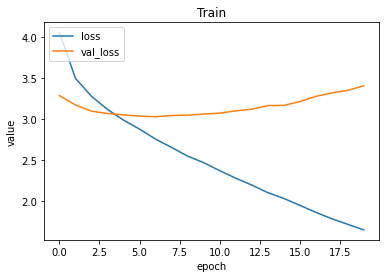

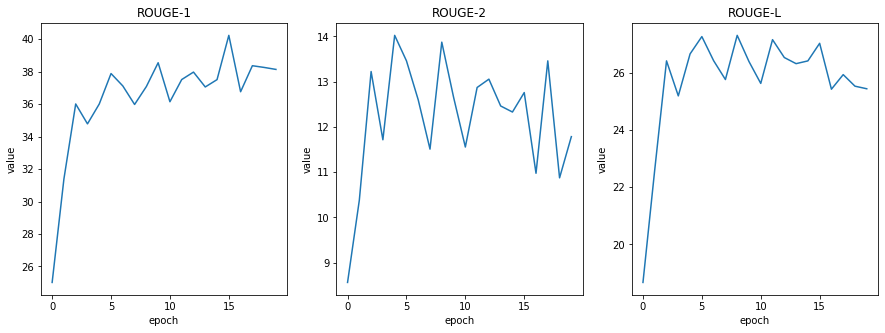

LOWEST VAL_LOSS at epoch : 7  -- loss :  2.758314371109009 val_loss :  3.031818151473999 ROUGE-1 :  37.1210365946791 ROUGE-2 :  12.596673314667298 ROUGE-L 26.417890508378406
BIGGEST ROUGE-1 at epoch : 16  -- loss :  1.9502100944519043 val_loss :  3.216019868850708 ROUGE-1 :  40.23783772179916 ROUGE-2 :  12.757548922354228 ROUGE-L 27.026660396428483
BIGGEST ROUGE-2 at epoch : 5  -- loss :  2.990675687789917 val_loss :  3.054368019104004 ROUGE-1 :  36.00745703187328 ROUGE-2 :  14.022298569711754 ROUGE-L 26.655621239513916
BIGGEST ROUGE-L at epoch : 9  -- loss :  2.5511245727539062 val_loss :  3.050753116607666 ROUGE-1 :  37.083799632371154 ROUGE-2 :  13.87194289313481 ROUGE-L 27.304379767015597


In [ ]:
history_path = "/content/drive/MyDrive/best_weights/PEGASUS_emails_history"
plot_all(history_path)
get_potential_models(history_path)

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/PEGASUS_emails/saved-model-07"
model_PEGASUS.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_emails, model_PEGASUS, tok_PEGASUS, batch_size = 5, name  = "PEGASUS") 
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 35.1804, 'rouge2': 11.476, 'rougeL': 25.9199, 'rougeLsum': 31.9787}
BERT scores  :   {'precision': 87.1036, 'recall': 86.8968, 'f1': 86.9969}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 30.1981, 'rouge2': 5.8182, 'rougeL': 20.7039, 'rougeLsum': 24.1997}
BERT scores  :   {'precision': 84.904, 'recall': 85.3345, 'f1': 85.1028}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 31.3303, 'rouge2': 7.8944, 'rougeL': 23.5542, 'rougeLsum': 28.758}
BERT scores  :   {'precision': 84.835, 'recall': 85.8076, 'f1': 85.3147}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 25.5178, 'rouge2': 5.1617, 'rougeL': 17.3888, 'rougeLsum': 21.4986}
BERT scores  :   {'precision': 85.2089, 'recall': 85.1122, 'f1': 85.155}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE       

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/PEGASUS_emails/saved-model-16"
model_PEGASUS.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_emails, model_PEGASUS, tok_PEGASUS, batch_size = 5, name  = "PEGASUS") 
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 39.4854, 'rouge2': 14.4779, 'rougeL': 27.692, 'rougeLsum': 37.6839}
BERT scores  :   {'precision': 88.0742, 'recall': 87.3019, 'f1': 87.6851}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 30.3695, 'rouge2': 6.5958, 'rougeL': 20.7784, 'rougeLsum': 26.1334}
BERT scores  :   {'precision': 85.5085, 'recall': 85.6729, 'f1': 85.5866}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 34.0284, 'rouge2': 9.5361, 'rougeL': 23.9284, 'rougeLsum': 30.718}
BERT scores  :   {'precision': 85.8836, 'recall': 87.2053, 'f1': 86.5353}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 38.5583, 'rouge2': 12.5845, 'rougeL': 24.56, 'rougeLsum': 33.9587}
BERT scores  :   {'precision': 87.3297, 'recall': 87.8345, 'f1': 87.5806}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE     

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/PEGASUS_emails/saved-model-09"
model_PEGASUS.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_emails, model_PEGASUS, tok_PEGASUS, batch_size = 5, name  = "PEGASUS") 
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 35.7738, 'rouge2': 12.1078, 'rougeL': 25.6713, 'rougeLsum': 32.5456}
BERT scores  :   {'precision': 87.4347, 'recall': 87.1772, 'f1': 87.3031}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 28.0095, 'rouge2': 5.736, 'rougeL': 19.9186, 'rougeLsum': 24.738}
BERT scores  :   {'precision': 85.5199, 'recall': 85.5838, 'f1': 85.5442}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 31.3752, 'rouge2': 8.3257, 'rougeL': 22.7854, 'rougeLsum': 27.815}
BERT scores  :   {'precision': 84.3224, 'recall': 86.4332, 'f1': 85.3616}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 32.5058, 'rouge2': 10.9131, 'rougeL': 23.877, 'rougeLsum': 28.1605}
BERT scores  :   {'precision': 86.3033, 'recall': 87.0557, 'f1': 86.6769}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE     

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/PEGASUS_emails/saved-model-16"
model_PEGASUS.load_weights(filepath)
show_gen_summaries(model_PEGASUS, tok_PEGASUS, tokenized_emails, min_len = 100 , shape = 512)


ORIGINAL

Martin states that the Snapshots with both diff markup and the change logs are now available. He
also states that these are the URLs that are members only and currently have an error in the Table
of Contents that have 'strange characters.'  Martin states that other parts are now available, and
the TOC errors have been corrected.

GENERATED

Martin Gudgin says that snapshots of parts 0, 1 and 2 will be available sans changelog for parts 1
and 2, as well as for parts 1 and 2, which are currently member-only and suffer from strange
characters in TOC. He also says that parts 1 and 2 will be fixed soon. He also says that parts 1 and
2 will be available sans changelog for parts 1 and 2. He also says that parts 1 and 2 will also be
available sans changelog for parts 1 and 2.
______________________________________________________________________________________________________

ORIGINAL

Michael states his case for no longer supporting the ordering or differences of time values, arg

# Nyt subset with PEGASUS

In [ ]:
nyt = preprocess_function_step_1("nyt")
tokenized_nyt = nyt.map(preprocess_function_PEGASUS_tokenizer, batched=True)
nyt_train_set, nyt_val_set, nyt_test_set, nyt_generation = get_tf_dataset_iterator(tokenized_nyt, batch_sizes = 4)

filepath = "/content/drive/MyDrive/best_weights/PEGASUS_nyt/saved-model-{epoch:02d}"
history_path = "/content/drive/MyDrive/best_weights/PEGASUS_nyt_history"

checkpoint = ModelCheckpoint(filepath,  verbose=1, save_weights_only = True, save_freq='epoch')

metric_callback = KerasMetricCallback(
    metric_fn_PEGASUS, eval_dataset=nyt_generation, predict_with_generate=True
)

In [ ]:
callbacks_list = [metric_callback, checkpoint]

with tf.device('/GPU:0'):
    history_nyt = model_PEGASUS.fit(x = nyt_train_set, validation_data = nyt_val_set, epochs=8, callbacks=callbacks_list) 

json.dump(history_nyt.history, open(history_path, 'w'))

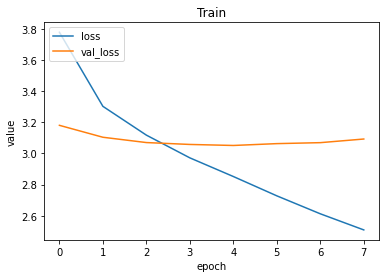

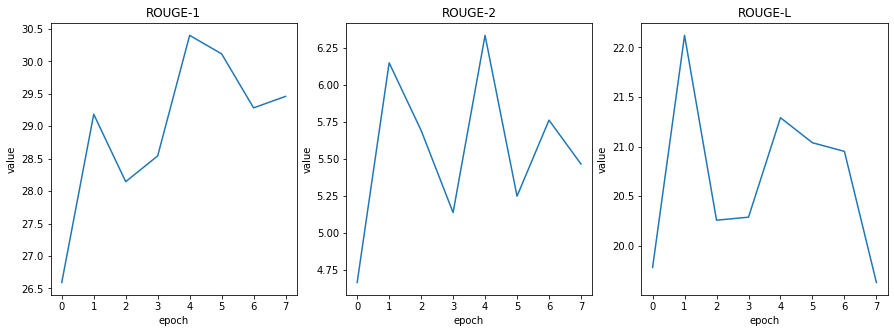

LOWEST VAL_LOSS at epoch : 5  -- loss :  2.85147762298584 val_loss :  3.050837993621826 ROUGE-1 :  30.40086710309582 ROUGE-2 :  6.334246837000866 ROUGE-L 21.29086922008842
BIGGEST ROUGE-1 at epoch : 5  -- loss :  2.85147762298584 val_loss :  3.050837993621826 ROUGE-1 :  30.40086710309582 ROUGE-2 :  6.334246837000866 ROUGE-L 21.29086922008842
BIGGEST ROUGE-2 at epoch : 5  -- loss :  2.85147762298584 val_loss :  3.050837993621826 ROUGE-1 :  30.40086710309582 ROUGE-2 :  6.334246837000866 ROUGE-L 21.29086922008842
BIGGEST ROUGE-L at epoch : 2  -- loss :  3.302072763442993 val_loss :  3.1036081314086914 ROUGE-1 :  29.184405962442472 ROUGE-2 :  6.148949873077901 ROUGE-L 22.121219216207287


In [ ]:
history_path = "/content/drive/MyDrive/best_weights/PEGASUS_nyt_history"
plot_all(history_path)
get_potential_models(history_path)

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/PEGASUS_nyt/saved-model-05"
model_PEGASUS.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_nyt, model_PEGASUS, tok_PEGASUS, batch_size = 5, name  = "PEGASUS") 
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 23.0207, 'rouge2': 4.298, 'rougeL': 17.4184, 'rougeLsum': 18.9952}
BERT scores  :   {'precision': 84.7587, 'recall': 85.7069, 'f1': 85.2274}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 26.7666, 'rouge2': 6.3209, 'rougeL': 17.8712, 'rougeLsum': 22.2031}
BERT scores  :   {'precision': 84.1079, 'recall': 87.1154, 'f1': 85.528}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 25.186, 'rouge2': 5.61, 'rougeL': 19.6455, 'rougeLsum': 22.2648}
BERT scores  :   {'precision': 84.836, 'recall': 85.4226, 'f1': 85.1264}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 25.7898, 'rouge2': 5.8791, 'rougeL': 20.3599, 'rougeLsum': 20.0867}
BERT scores  :   {'precision': 84.7503, 'recall': 85.3042, 'f1': 85.0251}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE        :

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/PEGASUS_nyt/saved-model-05"
model_PEGASUS.load_weights(filepath)
a = show_gen_summaries(model_PEGASUS, tok_PEGASUS, tokenized_nyt, min_len = 100 , shape = 512, start_interval = 35, end_interval = 40)
print(a)

[["Several commenters chide readers for being so obsessed with Westbrook and suggest they are ignoring more significant events. One commenter responds in a lengthy post suggesting that the character gets his unwarranted publicity by being obnoxious. Others counter the position by admitting Westbrook's talent on the field while saying he is not so amazing as to deserve all the attention he has received.\n", 'Most commenters agree that Russell Westbrook is talented, entertaining, enigmatic, quirky, and caring human being who is involved in his community and puts on a great show. One commenter says that basketball is a form of entertainment and that Westbrook puts on a great show. One commenter says that basketball is a form of entertainment and that Westbrook puts on a great show. One commenter says that basketball is a form of entertainment and that Westbrook puts on a great show. One commenter says that basketball is a form of entertainment and that Westbrook puts on a great show.'], [

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/PEGASUS_nyt/saved-model-05"
model_PEGASUS.load_weights(filepath)
show_gen_summaries(model_PEGASUS, tok_PEGASUS, tokenized_nyt, min_len = 100 , shape = 512)


ORIGINAL

Several of the commenters talk about their long histories as Cub fans and how nice it was to see the
cubs play in the World Series, often talking about past family members who also would have loved to
have seen it. Others are critical of the announcers, ESPN, and Cubs fans. The user critical of ESPN
says that they "own" baseball and that they have too much power over things such as requiring there
be night games.

GENERATED

Most of the commenters praise the Cubs for their long-awaited World Series victory, with one
commenter saying that the team is the best team in baseball and the championship is rightfully
theirs. One commenter says that the team is the best in baseball, and another says that the team is
the best in the world. One commenter says that the team is the best in baseball, and another says
that the team is the best in the world. One commenter says that the team is the best in baseball,
and another says that the team is the best in the world. One commenter says 

# Reddit subset with PEGASUS

In [ ]:
reddit = preprocess_function_step_1("reddit")
tokenized_reddit = reddit.map(preprocess_function_PEGASUS_tokenizer, batched=True)
reddit_train_set, reddit_val_set, reddit_test_set, reddit_generation = get_tf_dataset_iterator(tokenized_reddit, batch_sizes = 4)

filepath = "/content/drive/MyDrive/best_weights/PEGASUS_reddit/saved-model-{epoch:02d}"
history_path = "/content/drive/MyDrive/best_weights/PEGASUS_reddit_history"

checkpoint = ModelCheckpoint(filepath,  verbose=1, save_weights_only = True, save_freq='epoch')

metric_callback = KerasMetricCallback(
    metric_fn_PEGASUS, eval_dataset=reddit_generation, predict_with_generate=True
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
callbacks_list = [metric_callback, checkpoint]

with tf.device('/GPU:0'):
    history_reddit = model_PEGASUS.fit(x = reddit_train_set, validation_data = reddit_val_set, epochs=8, callbacks=callbacks_list) 

json.dump(history_reddit.history, open(history_path, 'w'))

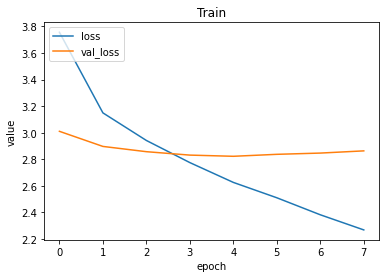

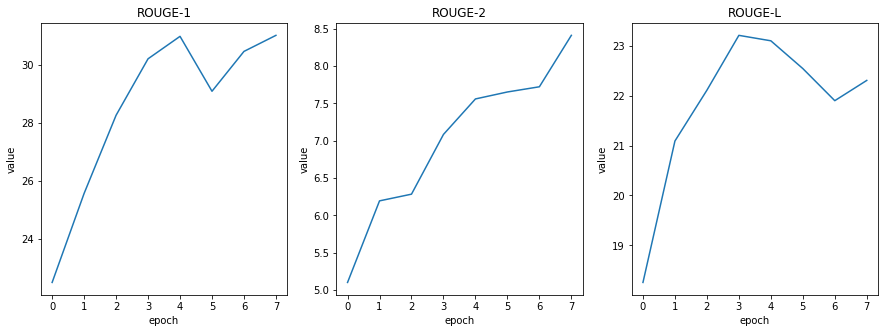

LOWEST VAL_LOSS at epoch : 5  -- loss :  2.625394344329834 val_loss :  2.822136402130127 ROUGE-1 :  30.994214192932358 ROUGE-2 :  7.559861829236607 ROUGE-L 23.099223215146626
BIGGEST ROUGE-1 at epoch : 8  -- loss :  2.2674601078033447 val_loss :  2.8629841804504395 ROUGE-1 :  31.02850060006229 ROUGE-2 :  8.41222136240434 ROUGE-L 22.305322550583107
BIGGEST ROUGE-2 at epoch : 8  -- loss :  2.2674601078033447 val_loss :  2.8629841804504395 ROUGE-1 :  31.02850060006229 ROUGE-2 :  8.41222136240434 ROUGE-L 22.305322550583107
BIGGEST ROUGE-L at epoch : 4  -- loss :  2.774583339691162 val_loss :  2.831111431121826 ROUGE-1 :  30.220120414157293 ROUGE-2 :  7.084037754086353 ROUGE-L 23.20832121625373


In [ ]:
history_path = "/content/drive/MyDrive/best_weights/PEGASUS_reddit_history"
plot_all(history_path)
get_potential_models(history_path)

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/PEGASUS_reddit/saved-model-05"
model_PEGASUS.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_reddit, model_PEGASUS, tok_PEGASUS, batch_size = 5, name = "PEGASUS")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 22.5404, 'rouge2': 4.5417, 'rougeL': 19.2809, 'rougeLsum': 17.3857}
BERT scores  :   {'precision': 85.1345, 'recall': 85.1408, 'f1': 85.1342}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 20.5688, 'rouge2': 4.352, 'rougeL': 19.8224, 'rougeLsum': 16.0891}
BERT scores  :   {'precision': 85.0187, 'recall': 85.3903, 'f1': 85.2014}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 27.0131, 'rouge2': 6.849, 'rougeL': 24.5594, 'rougeLsum': 23.434}
BERT scores  :   {'precision': 85.5529, 'recall': 86.9928, 'f1': 86.2618}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 24.8548, 'rouge2': 7.5242, 'rougeL': 22.8331, 'rougeLsum': 20.9359}
BERT scores  :   {'precision': 84.4087, 'recall': 85.7195, 'f1': 85.0485}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE      

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/PEGASUS_reddit/saved-model-08"
model_PEGASUS.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_reddit, model_PEGASUS, tok_PEGASUS, batch_size = 5, name = "PEGASUS")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 27.1056, 'rouge2': 6.5962, 'rougeL': 21.6568, 'rougeLsum': 20.5222}
BERT scores  :   {'precision': 85.8949, 'recall': 86.2264, 'f1': 86.0568}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 20.2785, 'rouge2': 3.7516, 'rougeL': 18.6384, 'rougeLsum': 17.4981}
BERT scores  :   {'precision': 84.8738, 'recall': 85.5825, 'f1': 85.2238}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 29.1885, 'rouge2': 7.6988, 'rougeL': 21.5468, 'rougeLsum': 22.9969}
BERT scores  :   {'precision': 85.6635, 'recall': 86.953, 'f1': 86.2964}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 28.4478, 'rouge2': 7.4405, 'rougeL': 21.024, 'rougeLsum': 25.5052}
BERT scores  :   {'precision': 85.2725, 'recall': 87.4853, 'f1': 86.3594}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE     

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/PEGASUS_reddit/saved-model-08"
model_PEGASUS.load_weights(filepath)

tok = tok_PEGASUS
mod = model_PEGASUS
tokenized_data = tokenized_reddit

inputs = np.squeeze(np.array([tokenized_data["test"]["input_ids"]]))
summas = tokenized_data["test"]["summary"]
gold_summaries = np.squeeze(np.array([tokenized_data["test"]["labels"]]))

for i in range(10,len(inputs)):
  decoded_labels = tok.batch_decode(gold_summaries[i], skip_special_tokens=True)
  print("\nORIGINAL\n")
  print(textwrap.fill(summas[i], 100))
  summary_ids = mod.generate(inputs[i].reshape(1,512), num_beams=4, max_length = 125, min_length = 100)
  decoded_preds = tok.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
  print("\nGENERATED\n")
  print(textwrap.fill(decoded_preds[0], 100))
  print("______________________________________________________________________________________________________")
  if i  == 14:
    break


ORIGINAL

Some commenters say that one has to pay to change their name. One commenter includes a link to
origin.com, which allows user to change their name. Another says that changing the username will
change the soldier name too. Another commenter adds that the change option is currently unavailable.

GENERATED

Commenters agree that it is not possible to change the name of a soldier. One commenter says that it
is only for PC and Xbox. Another commenter says that it is only for PC. Another commenter says that
it is not possible to change the name of a soldier. Another commenter says that it is not possible
to change the name of a soldier. Another commenter says that it is not possible to change the name
of a soldier. Another commenter says that it is not possible to change the name of a soldier.
______________________________________________________________________________________________________

ORIGINAL

The commenters ask the poster questions, mainly about themself. One asks abou

# Stack subset with PEGASUS

In [ ]:
stack = preprocess_function_step_1("stack")
tokenized_stack = stack.map(preprocess_function_PEGASUS_tokenizer, batched=True)
stack_train_set, stack_val_set, stack_test_set, stack_generation = get_tf_dataset_iterator(tokenized_stack, batch_sizes = 4)

filepath = "/content/drive/MyDrive/best_weights/PEGASUS_stack/saved-model-{epoch:02d}"
history_path = "/content/drive/MyDrive/best_weights/PEGASUS_stack_history"

checkpoint = ModelCheckpoint(filepath,  verbose=1, save_weights_only = True, save_freq='epoch')

metric_callback = KerasMetricCallback(
    metric_fn_PEGASUS, eval_dataset=stack_generation, predict_with_generate=True
)

Parameter 'function'=<function preprocess_function_PEGASUS_tokenizer at 0x7f0cb59fed40> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
callbacks_list = [metric_callback, checkpoint]

with tf.device('/GPU:0'):
    history_stack = model_PEGASUS.fit(x = stack_train_set, validation_data = stack_val_set, epochs=8, callbacks=callbacks_list) 

json.dump(history_stack.history, open(history_path, 'w'))

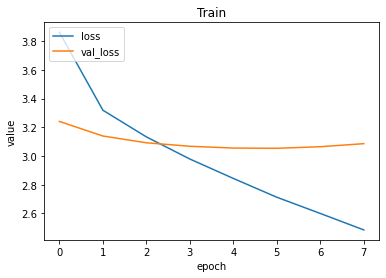

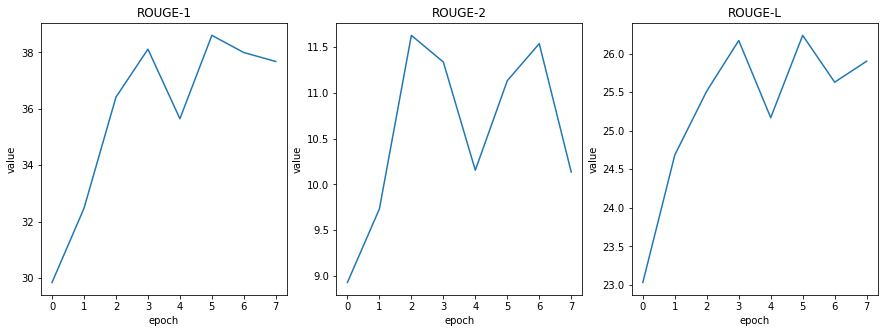

LOWEST VAL_LOSS at epoch : 6  -- loss :  2.712313652038574 val_loss :  3.053676128387451 ROUGE-1 :  38.607408714961814 ROUGE-2 :  11.130552587294414 ROUGE-L 26.236251071792083
BIGGEST ROUGE-1 at epoch : 6  -- loss :  2.712313652038574 val_loss :  3.053676128387451 ROUGE-1 :  38.607408714961814 ROUGE-2 :  11.130552587294414 ROUGE-L 26.236251071792083
BIGGEST ROUGE-2 at epoch : 3  -- loss :  3.133279800415039 val_loss :  3.092210054397583 ROUGE-1 :  36.4153990756767 ROUGE-2 :  11.625446667503759 ROUGE-L 25.51464411660398
BIGGEST ROUGE-L at epoch : 6  -- loss :  2.712313652038574 val_loss :  3.053676128387451 ROUGE-1 :  38.607408714961814 ROUGE-2 :  11.130552587294414 ROUGE-L 26.236251071792083


In [ ]:
history_path = "/content/drive/MyDrive/best_weights/PEGASUS_stack_history"
plot_all(history_path)
get_potential_models(history_path)

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/PEGASUS_stack/saved-model-06"
model_PEGASUS.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_stack, model_PEGASUS, tok_PEGASUS, batch_size = 5, name = "PEGASUS")  
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 32.1911, 'rouge2': 6.6711, 'rougeL': 22.5744, 'rougeLsum': 27.027}
BERT scores  :   {'precision': 86.0003, 'recall': 86.7611, 'f1': 86.3767}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 29.5256, 'rouge2': 5.858, 'rougeL': 23.1077, 'rougeLsum': 25.1716}
BERT scores  :   {'precision': 87.0838, 'recall': 87.0868, 'f1': 87.0836}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 27.1223, 'rouge2': 8.6608, 'rougeL': 22.9632, 'rougeLsum': 24.1364}
BERT scores  :   {'precision': 86.0183, 'recall': 86.146, 'f1': 86.0748}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 27.0888, 'rouge2': 7.2605, 'rougeL': 20.7244, 'rougeLsum': 23.2488}
BERT scores  :   {'precision': 84.9819, 'recall': 86.4726, 'f1': 85.6911}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE      

In [ ]:
show_gen_summaries(model_PEGASUS, tok_PEGASUS, tokenized_stack, min_len = 100 , shape = 512)


ORIGINAL

Many commentators give suggestions for a circuit, either to improve his current one or to give him a
new one. Several commentators say that the zeners are backward, but one says that they’re just fine.
One commentator recommends an opamp, and another gives a product link for an AC output.

GENERATED

Commentators generally agree that a 12V wall power source can be used to create a symmetric power
source. One commentator suggests using an opamp to make the ground point, while another suggests
using a regulator to simulate the circuit. A few commentators suggest using a circuit that can
simulate the circuit. One commentator suggests using a circuit that can simulate the circuit, while
another suggests using a circuit that can simulate the circuit. One commentator suggests using a
circuit that can simulate the circuit. One commentator suggests using a circuit that can simulate
the circuit.
_________________________________________________________________________________________

# Full dataset with PEGASUS

In [ ]:

convoSum = preprocess_function_step_1(None)
tokenized_convoSum = convoSum.map(preprocess_function_PEGASUS_tokenizer, batched=True)
convoSum_train_set, convoSum_val_set, convoSum_test_set, convoSum_generation= get_tf_dataset_iterator(tokenized_convoSum, batch_sizes = 4)

filepath = "/content/drive/MyDrive/best_weights/PEGASUS_convoSum/saved-model-{epoch:02d}"
history_path = "/content/drive/MyDrive/best_weights/PEGASUS_convoSum_history"

checkpoint = ModelCheckpoint(filepath,  verbose=1, save_weights_only = True, save_freq='epoch')

metric_callback = KerasMetricCallback(
    metric_fn_PEGASUS, eval_dataset=convoSum_generation, predict_with_generate=True
)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
callbacks_list = [checkpoint]

with tf.device('/GPU:0'):
    history_convoSum = model_PEGASUS.fit(x = convoSum_train_set, validation_data = convoSum_val_set, epochs=8, callbacks=callbacks_list)

json.dump(history_convoSum.history, open(history_path, 'w'))

Epoch 1/8
355/355 [==============================] - ETA: 0s - loss: 3.5927
Epoch 1: saving model to /content/drive/MyDrive/best_weights/PEGASUS_convoSum/saved-model-01
355/355 [==============================] - 448s 1s/step - loss: 3.5927 - val_loss: 3.0502
Epoch 2/8
355/355 [==============================] - ETA: 0s - loss: 3.1897
Epoch 2: saving model to /content/drive/MyDrive/best_weights/PEGASUS_convoSum/saved-model-02
355/355 [==============================] - 377s 1s/step - loss: 3.1897 - val_loss: 2.9657
Epoch 3/8
355/355 [==============================] - ETA: 0s - loss: 3.0122
Epoch 3: saving model to /content/drive/MyDrive/best_weights/PEGASUS_convoSum/saved-model-03
355/355 [==============================] - 378s 1s/step - loss: 3.0122 - val_loss: 2.9386
Epoch 4/8
355/355 [==============================] - ETA: 0s - loss: 2.8652
Epoch 4: saving model to /content/drive/MyDrive/best_weights/PEGASUS_convoSum/saved-model-04
355/355 [==============================] - 380s 1s/ste

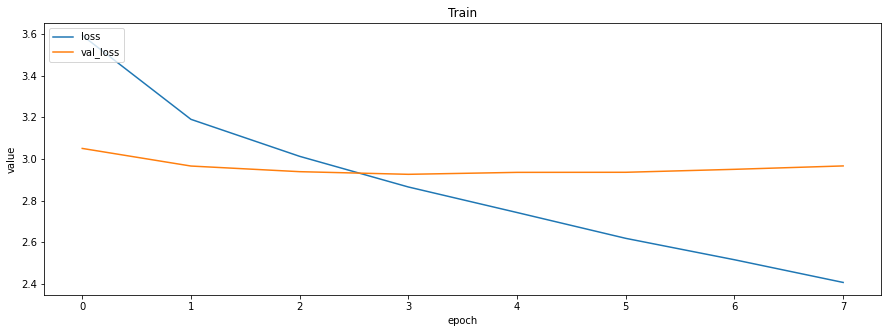

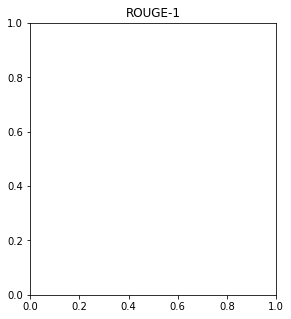

In [ ]:
history_path = "/content/drive/MyDrive/best_weights/PEGASUS_convoSum_history"
plot_all(history_path)
#get_potential_models(history_path)

In [ ]:
emails = preprocess_function_step_1("email")
tokenized_emails = emails.map(preprocess_function_PEGASUS_tokenizer, batched=True)

nyt = preprocess_function_step_1("nyt")
tokenized_nyt = nyt.map(preprocess_function_PEGASUS_tokenizer, batched=True)

reddit = preprocess_function_step_1("reddit")
tokenized_reddit = reddit.map(preprocess_function_PEGASUS_tokenizer, batched=True)

stack = preprocess_function_step_1("stack")
tokenized_stack = stack.map(preprocess_function_PEGASUS_tokenizer, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/PEGASUS_convoSum/saved-model-08"
model_PEGASUS.load_weights(filepath)

In [ ]:
rouge_a, bert_a = show_metrics_nice(tokenized_emails, model_PEGASUS, tok_PEGASUS, batch_size = 5, name = "PEGASUS")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 40.8166, 'rouge2': 18.0965, 'rougeL': 31.2226, 'rougeLsum': 36.1111}
BERT scores  :   {'precision': 87.8149, 'recall': 87.6504, 'f1': 87.7301}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 32.268, 'rouge2': 8.8585, 'rougeL': 21.9837, 'rougeLsum': 27.7281}
BERT scores  :   {'precision': 85.6036, 'recall': 85.9333, 'f1': 85.7603}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 29.0924, 'rouge2': 8.2655, 'rougeL': 21.7193, 'rougeLsum': 25.9345}
BERT scores  :   {'precision': 84.7448, 'recall': 85.7338, 'f1': 85.2358}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 32.0538, 'rouge2': 9.9783, 'rougeL': 21.8058, 'rougeLsum': 27.1349}
BERT scores  :   {'precision': 87.1307, 'recall': 86.9962, 'f1': 87.0595}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE   

In [ ]:
rouge_a, bert_a = show_metrics_nice(tokenized_nyt, model_PEGASUS, tok_PEGASUS, batch_size = 5, name = "PEGASUS")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 26.3093, 'rouge2': 5.4646, 'rougeL': 17.6769, 'rougeLsum': 22.6805}
BERT scores  :   {'precision': 84.6652, 'recall': 86.2671, 'f1': 85.4558}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 28.1413, 'rouge2': 6.3024, 'rougeL': 20.9841, 'rougeLsum': 22.0758}
BERT scores  :   {'precision': 85.7102, 'recall': 86.6569, 'f1': 86.1734}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 23.3861, 'rouge2': 4.7616, 'rougeL': 17.9667, 'rougeLsum': 18.6368}
BERT scores  :   {'precision': 84.4367, 'recall': 85.3294, 'f1': 84.8777}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 20.9402, 'rouge2': 2.5914, 'rougeL': 16.3019, 'rougeLsum': 18.4437}
BERT scores  :   {'precision': 85.2258, 'recall': 85.7329, 'f1': 85.4733}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE   

In [ ]:
rouge_a, bert_a = show_metrics_nice(tokenized_reddit, model_PEGASUS, tok_PEGASUS, batch_size = 5, name = "PEGASUS")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 24.542, 'rouge2': 6.6174, 'rougeL': 22.7797, 'rougeLsum': 19.6561}
BERT scores  :   {'precision': 85.1944, 'recall': 85.7163, 'f1': 85.4521}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 23.8318, 'rouge2': 5.5544, 'rougeL': 18.8382, 'rougeLsum': 19.9428}
BERT scores  :   {'precision': 84.9592, 'recall': 86.2037, 'f1': 85.5672}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 24.9404, 'rouge2': 7.791, 'rougeL': 19.5888, 'rougeLsum': 21.4934}
BERT scores  :   {'precision': 85.9267, 'recall': 87.0024, 'f1': 86.4581}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 26.83, 'rouge2': 5.7289, 'rougeL': 22.5031, 'rougeLsum': 22.4452}
BERT scores  :   {'precision': 83.921, 'recall': 86.3697, 'f1': 85.1026}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE        

In [ ]:
rouge_a, bert_a = show_metrics_nice(tokenized_stack, model_PEGASUS, tok_PEGASUS, batch_size = 5, name = "PEGASUS")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 33.1235, 'rouge2': 7.6742, 'rougeL': 23.3752, 'rougeLsum': 28.0542}
BERT scores  :   {'precision': 86.6428, 'recall': 87.1422, 'f1': 86.8903}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 32.1684, 'rouge2': 8.7647, 'rougeL': 23.8502, 'rougeLsum': 29.4145}
BERT scores  :   {'precision': 87.1772, 'recall': 86.8625, 'f1': 87.0117}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 25.0687, 'rouge2': 8.3061, 'rougeL': 20.2448, 'rougeLsum': 22.3386}
BERT scores  :   {'precision': 85.4907, 'recall': 85.8803, 'f1': 85.6837}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 28.0346, 'rouge2': 6.9811, 'rougeL': 20.968, 'rougeLsum': 22.8414}
BERT scores  :   {'precision': 86.3316, 'recall': 86.2874, 'f1': 86.3066}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE    

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Initializing T5

In [ ]:
model_checkpoint = "t5-base"
#model_checkpoint = "sumedh/t5-base-amazonreviews"

model_T5 = TFT5ForConditionalGeneration.from_pretrained(model_checkpoint, from_pt=True )
tok_T5 = AutoTokenizer.from_pretrained(model_checkpoint)

# Use DataCollatorForSeq2Seq to create a batch of examples
data_collator = DataCollatorForSeq2Seq(tokenizer=tok_T5, model=model_T5, return_tensors="tf")

metric = load_metric('rouge')
bertscore = load("bertscore")

# Set up an optimizer function.#2e-5
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)#4e-6

model_T5.compile(optimizer=optimizer)


model_T5.summary()

#435,375,104 pegasus
#222,903,552 t5-base
#737,639,424 henryu-lin/t5-large-samsum-deepspeed
#222,903,552 sumedh/t5-base-amazonreviews

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:166: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, ple

Model: "tft5_for_conditional_generation_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (TFSharedEmbeddings)  multiple                 24674304  
                                                                 
 encoder (TFT5MainLayer)     multiple                  84954240  
                                                                 
 decoder (TFT5MainLayer)     multiple                  113275008 
                                                                 
Total params: 222,903,552
Trainable params: 222,903,552
Non-trainable params: 0
_________________________________________________________________


# E-mails subset with T5

In [ ]:
emails = preprocess_function_step_1("email")
tokenized_emails = emails.map(preprocess_function_T5_tokenizer, batched=True)
emails_train_set, emails_val_set, emails_test_set, emails_generation  = get_tf_dataset_iterator(tokenized_emails, batch_sizes = 4)

filepath = "/content/drive/MyDrive/best_weights/T5_emails/saved-model-{epoch:02d}"
history_path = "/content/drive/MyDrive/best_weights/T5_emails_history"

checkpoint = ModelCheckpoint(filepath,  verbose=1, save_weights_only = True, save_freq='epoch')

metric_callback = KerasMetricCallback(
    metric_fn_T5, eval_dataset=emails_generation, predict_with_generate=True
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
callbacks_list = [metric_callback, checkpoint]

with tf.device('/GPU:0'):
    history_emails = model_T5.fit(x = emails_train_set, validation_data = emails_val_set, epochs=10, callbacks=callbacks_list) 

json.dump(history_emails.history, open(history_path, 'w'))

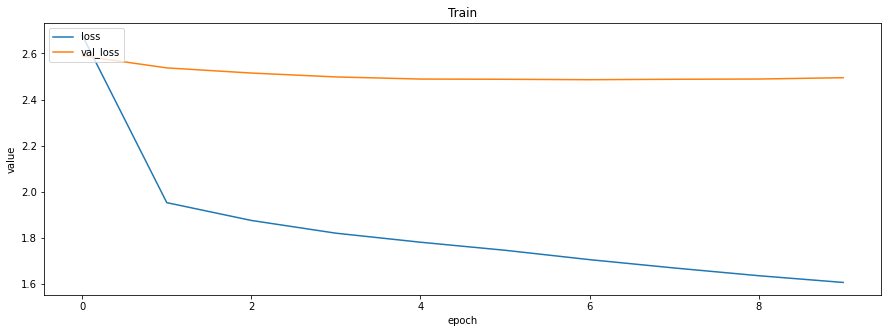

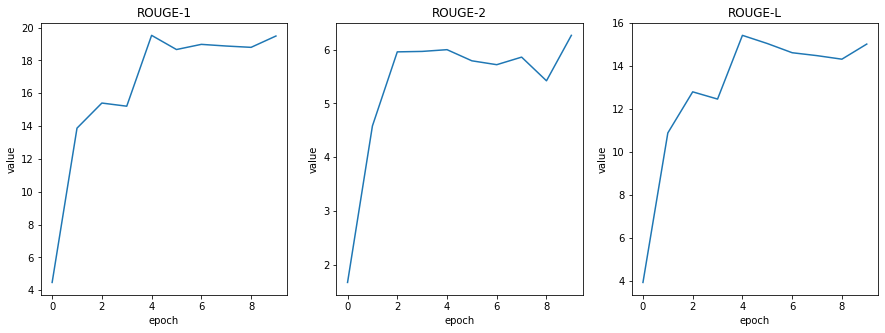

LOWEST VAL_LOSS at epoch : 7  -- loss :  1.7062886953353882 val_loss :  2.4862492084503174 ROUGE-1 :  18.97371516772554 ROUGE-2 :  5.719562203770489 ROUGE-L 14.619418903773099
BIGGEST ROUGE-1 at epoch : 5  -- loss :  1.7818260192871094 val_loss :  2.489056348800659 ROUGE-1 :  19.522165134054458 ROUGE-2 :  5.998800293643777 ROUGE-L 15.426628874837158
BIGGEST ROUGE-2 at epoch : 10  -- loss :  1.6074399948120117 val_loss :  2.494831085205078 ROUGE-1 :  19.48182616313168 ROUGE-2 :  6.2651291239232965 ROUGE-L 15.021531649110692
BIGGEST ROUGE-L at epoch : 5  -- loss :  1.7818260192871094 val_loss :  2.489056348800659 ROUGE-1 :  19.522165134054458 ROUGE-2 :  5.998800293643777 ROUGE-L 15.426628874837158


In [ ]:
history_path = "/content/drive/MyDrive/best_weights/T5_emails_history"
plot_all(history_path)
get_potential_models(history_path)

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/T5_emails/saved-model-08"
model_T5.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_emails, model_T5, tok_T5, batch_size = 5, name = "T5") 
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 38.9425, 'rouge2': 12.5715, 'rougeL': 22.5667, 'rougeLsum': 34.5591}
BERT scores  :   {'precision': 87.4705, 'recall': 87.4134, 'f1': 87.4383}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 35.0939, 'rouge2': 9.8329, 'rougeL': 21.7349, 'rougeLsum': 32.1202}
BERT scores  :   {'precision': 86.0455, 'recall': 86.9812, 'f1': 86.5033}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 37.4043, 'rouge2': 14.063, 'rougeL': 27.1573, 'rougeLsum': 33.9258}
BERT scores  :   {'precision': 86.0665, 'recall': 87.1911, 'f1': 86.6231}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 37.8418, 'rouge2': 13.9868, 'rougeL': 25.3201, 'rougeLsum': 35.3672}
BERT scores  :   {'precision': 87.9486, 'recall': 87.7413, 'f1': 87.8439}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE 

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/T5_emails/saved-model-10"
model_T5.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_emails, model_T5, tok_T5, batch_size = 5, name = "T5") 
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 40.0678, 'rouge2': 12.8708, 'rougeL': 24.1037, 'rougeLsum': 35.0723}
BERT scores  :   {'precision': 87.8817, 'recall': 87.772, 'f1': 87.824}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 38.5627, 'rouge2': 11.4573, 'rougeL': 23.0166, 'rougeLsum': 35.0963}
BERT scores  :   {'precision': 85.9672, 'recall': 87.3202, 'f1': 86.631}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 40.7133, 'rouge2': 17.4612, 'rougeL': 30.1119, 'rougeLsum': 36.9202}
BERT scores  :   {'precision': 86.2015, 'recall': 87.5946, 'f1': 86.8877}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 39.4088, 'rouge2': 13.7255, 'rougeL': 25.1343, 'rougeLsum': 34.8858}
BERT scores  :   {'precision': 88.2426, 'recall': 88.0267, 'f1': 88.1334}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE  

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/T5_emails/saved-model-10"
model_T5.load_weights(filepath)
show_gen_summaries(model_T5, tok_T5, tokenized_emails, min_len = 100 , shape = 512)


ORIGINAL

Martin states that the Snapshots with both diff markup and the change logs are now available. He
also states that these are the URLs that are members only and currently have an error in the Table
of Contents that have 'strange characters.'  Martin states that other parts are now available, and
the TOC errors have been corrected.

GENERATED

Martin Gudgin says that the editors have prepared PR snapshots of Parts 0[0], 1[1] for Parts 1 and 2
that include diff markup. He also says that Snapshots sans diff markup will appear shortly followed
by snapshots sans change logs. Gudgin says that URLs are member-only and suffer from the 'strange
characters in TOC' problem. He also says that Snapshots sans change logs are now available for Parts
0[5], 1[6 and 2[7.
______________________________________________________________________________________________________

ORIGINAL

Michael states his case for no longer supporting the ordering or differences of time values, arguing
that the use

# Nyt subset with T5

In [ ]:
nyt = preprocess_function_step_1("nyt")
tokenized_nyt = nyt.map(preprocess_function_T5_tokenizer, batched=True)
nyt_train_set, nyt_val_set, nyt_test_set, nyt_generation  = get_tf_dataset_iterator(tokenized_nyt, batch_sizes = 4)

filepath = "/content/drive/MyDrive/best_weights/T5_nyt/saved-model-{epoch:02d}"
history_path = "/content/drive/MyDrive/best_weights/T5_nyt_history"

checkpoint = ModelCheckpoint(filepath,  verbose=1, save_weights_only = True, save_freq='epoch')

metric_callback = KerasMetricCallback(
    metric_fn_T5, eval_dataset=nyt_generation, predict_with_generate=True
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
callbacks_list = [metric_callback, checkpoint]

with tf.device('/GPU:0'):
    history_nyt = model_T5.fit(x = nyt_train_set, validation_data = nyt_val_set, epochs=10, callbacks=callbacks_list) 

json.dump(history_nyt.history, open(history_path, 'w'))

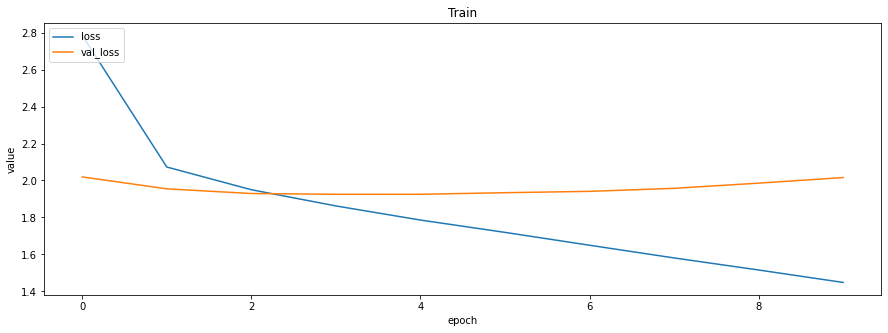

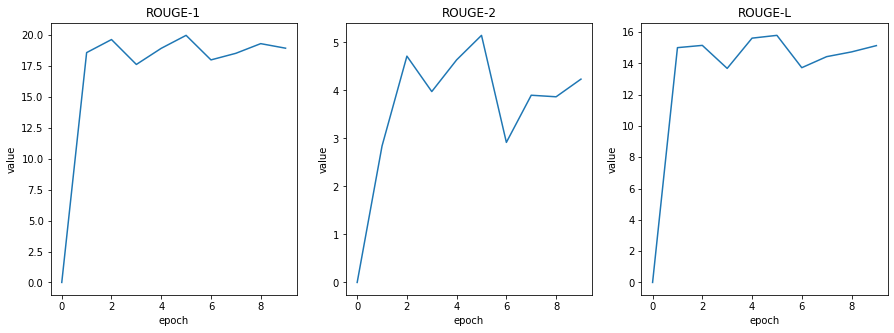

LOWEST VAL_LOSS at epoch : 4  -- loss :  1.8622580766677856 val_loss :  1.925243854522705 ROUGE-1 :  17.63548075637294 ROUGE-2 :  3.9760641865041606 ROUGE-L 13.674580402965193
BIGGEST ROUGE-1 at epoch : 6  -- loss :  1.7190994024276733 val_loss :  1.933829426765442 ROUGE-1 :  19.98938467873093 ROUGE-2 :  5.146704971209264 ROUGE-L 15.785322825248594
BIGGEST ROUGE-2 at epoch : 6  -- loss :  1.7190994024276733 val_loss :  1.933829426765442 ROUGE-1 :  19.98938467873093 ROUGE-2 :  5.146704971209264 ROUGE-L 15.785322825248594
BIGGEST ROUGE-L at epoch : 6  -- loss :  1.7190994024276733 val_loss :  1.933829426765442 ROUGE-1 :  19.98938467873093 ROUGE-2 :  5.146704971209264 ROUGE-L 15.785322825248594


[2.019243001937866,
 1.9547386169433594,
 1.9294168949127197,
 1.925243854522705,
 1.9252949953079224,
 1.933829426765442,
 1.9411404132843018,
 1.9575117826461792,
 1.9855504035949707,
 2.015821695327759]

In [ ]:
history_path = "/content/drive/MyDrive/best_weights/T5_nyt_history"
plot_all(history_path)
get_potential_models(history_path)
history = json.load(open(history_path, 'r'))
history["val_loss"]

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/T5_nyt/saved-model-06"
model_T5.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_nyt, model_T5, tok_T5, batch_size = 5, name = "T5") 
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 28.3177, 'rouge2': 5.9503, 'rougeL': 17.8786, 'rougeLsum': 24.9878}
BERT scores  :   {'precision': 85.7429, 'recall': 86.5677, 'f1': 86.1518}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 27.9975, 'rouge2': 6.2175, 'rougeL': 18.6689, 'rougeLsum': 21.8469}
BERT scores  :   {'precision': 85.4498, 'recall': 86.4439, 'f1': 85.935}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 28.9978, 'rouge2': 6.0021, 'rougeL': 19.4666, 'rougeLsum': 25.8818}
BERT scores  :   {'precision': 85.4422, 'recall': 86.2771, 'f1': 85.8525}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 20.8725, 'rouge2': 4.2266, 'rougeL': 17.019, 'rougeLsum': 18.3931}
BERT scores  :   {'precision': 84.8433, 'recall': 85.7395, 'f1': 85.2876}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE     

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/T5_nyt/saved-model-10"
model_T5.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_nyt, model_T5, tok_T5, batch_size = 5, name = "T5") 
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 30.941, 'rouge2': 7.0517, 'rougeL': 20.1316, 'rougeLsum': 27.0999}
BERT scores  :   {'precision': 85.8366, 'recall': 86.8622, 'f1': 86.3458}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 29.2587, 'rouge2': 7.8797, 'rougeL': 20.2655, 'rougeLsum': 26.1067}
BERT scores  :   {'precision': 86.2432, 'recall': 87.3409, 'f1': 86.784}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 29.4894, 'rouge2': 5.9963, 'rougeL': 19.7849, 'rougeLsum': 26.1671}
BERT scores  :   {'precision': 86.3554, 'recall': 86.4698, 'f1': 86.4105}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 26.9348, 'rouge2': 5.0537, 'rougeL': 19.7209, 'rougeLsum': 25.3413}
BERT scores  :   {'precision': 85.3069, 'recall': 86.0729, 'f1': 85.6857}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE     

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/T5_nyt/saved-model-06"
model_T5.load_weights(filepath)
show_gen_summaries(model_T5, tok_T5, tokenized_nyt, min_len = 100 , shape = 512)


ORIGINAL

Several of the commenters talk about their long histories as Cub fans and how nice it was to see the
cubs play in the World Series, often talking about past family members who also would have loved to
have seen it. Others are critical of the announcers, ESPN, and Cubs fans. The user critical of ESPN
says that they "own" baseball and that they have too much power over things such as requiring there
be night games.

GENERATED

Many commenters agree that the Cubs are the best team in baseball and that they deserve the World
Series title. One commenter says that the only thing that made this work was the acquisition of both
Theo and Joe Maddon. Another commenter says that the bullpen has outlived its usefulness. One
commenter says that the Cubs are the best team in baseball and that they deserve the title. Another
commenter says that the Cubs are the best team in baseball and that they deserve the title.
___________________________________________________________________________

# Reddit subset with T5

In [ ]:
reddit = preprocess_function_step_1("reddit")
tokenized_reddit = reddit.map(preprocess_function_T5_tokenizer, batched=True)
reddit_train_set, reddit_val_set, reddit_test_set, reddit_generation  = get_tf_dataset_iterator(tokenized_reddit, batch_sizes = 4)

filepath = "/content/drive/MyDrive/best_weights/T5_reddit/saved-model-{epoch:02d}"
history_path = "/content/drive/MyDrive/best_weights/T5_reddit_history"

checkpoint = ModelCheckpoint(filepath,  verbose=1, save_weights_only = True, save_freq='epoch')

metric_callback = KerasMetricCallback(
    metric_fn_T5, eval_dataset=reddit_generation, predict_with_generate=True
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
callbacks_list = [metric_callback, checkpoint]

with tf.device('/GPU:0'):
    history_reddit = model_T5.fit(x = reddit_train_set, validation_data = reddit_val_set, epochs=10, callbacks=callbacks_list) 

json.dump(history_reddit.history, open(history_path, 'w'))

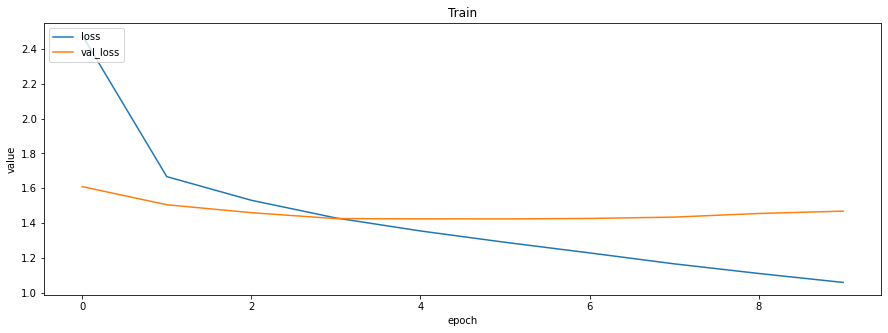

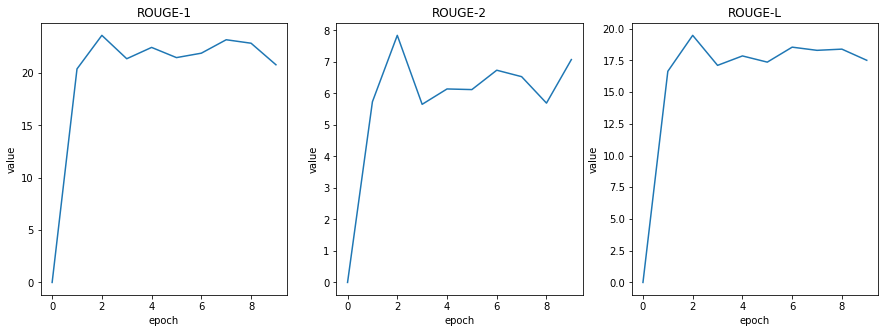

LOWEST VAL_LOSS at epoch : 6  -- loss :  1.2891687154769897 val_loss :  1.4236217737197876 ROUGE-1 :  21.478390605681025 ROUGE-2 :  6.1230070700218535 ROUGE-L 17.361152922905433
BIGGEST ROUGE-1 at epoch : 3  -- loss :  1.5307632684707642 val_loss :  1.459322214126587 ROUGE-1 :  23.60413009342837 ROUGE-2 :  7.844772157999413 ROUGE-L 19.470845574635764
BIGGEST ROUGE-2 at epoch : 3  -- loss :  1.5307632684707642 val_loss :  1.459322214126587 ROUGE-1 :  23.60413009342837 ROUGE-2 :  7.844772157999413 ROUGE-L 19.470845574635764
BIGGEST ROUGE-L at epoch : 3  -- loss :  1.5307632684707642 val_loss :  1.459322214126587 ROUGE-1 :  23.60413009342837 ROUGE-2 :  7.844772157999413 ROUGE-L 19.470845574635764


[1.609198808670044,
 1.5050448179244995,
 1.459322214126587,
 1.4252796173095703,
 1.4240233898162842,
 1.4236217737197876,
 1.4261773824691772,
 1.433929443359375,
 1.4547502994537354,
 1.4683338403701782]

In [ ]:
history_path = "/content/drive/MyDrive/best_weights/T5_reddit_history"
plot_all(history_path)
get_potential_models(history_path)
history = json.load(open(history_path, 'r'))
history["val_loss"]

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/T5_reddit/saved-model-06"
model_T5.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_reddit, model_T5, tok_T5, batch_size = 5, name = "T5")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 21.4562, 'rouge2': 4.4683, 'rougeL': 17.5269, 'rougeLsum': 17.0386}
BERT scores  :   {'precision': 85.5475, 'recall': 85.2754, 'f1': 85.4091}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 32.9976, 'rouge2': 7.0111, 'rougeL': 22.4865, 'rougeLsum': 28.2825}
BERT scores  :   {'precision': 86.6883, 'recall': 86.9385, 'f1': 86.8117}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 27.7108, 'rouge2': 6.3914, 'rougeL': 20.8824, 'rougeLsum': 24.3679}
BERT scores  :   {'precision': 85.6137, 'recall': 87.2327, 'f1': 86.3979}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 28.5176, 'rouge2': 9.028, 'rougeL': 24.1973, 'rougeLsum': 25.4746}
BERT scores  :   {'precision': 86.4218, 'recall': 87.2034, 'f1': 86.8057}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE    

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/T5_reddit/saved-model-10"
model_T5.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_reddit, model_T5, tok_T5, batch_size = 5, name = "T5")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 28.884, 'rouge2': 9.0085, 'rougeL': 22.3739, 'rougeLsum': 26.9814}
BERT scores  :   {'precision': 86.4212, 'recall': 86.7653, 'f1': 86.5887}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 32.7338, 'rouge2': 4.5221, 'rougeL': 20.874, 'rougeLsum': 28.9138}
BERT scores  :   {'precision': 87.0944, 'recall': 87.244, 'f1': 87.1671}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 27.6058, 'rouge2': 5.6414, 'rougeL': 17.9234, 'rougeLsum': 23.9225}
BERT scores  :   {'precision': 86.3005, 'recall': 86.7172, 'f1': 86.5015}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 30.9194, 'rouge2': 9.9564, 'rougeL': 22.8432, 'rougeLsum': 28.78}
BERT scores  :   {'precision': 87.0207, 'recall': 87.9364, 'f1': 87.4741}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE        

# Stack subset with T5

In [ ]:
stack = preprocess_function_step_1("stack")
tokenized_stack = stack.map(preprocess_function_T5_tokenizer, batched=True)
stack_train_set, stack_val_set, stack_test_set, stack_generation  = get_tf_dataset_iterator(tokenized_stack, batch_sizes = 4)

filepath = "/content/drive/MyDrive/best_weights/T5_stack/saved-model-{epoch:02d}"
history_path = "/content/drive/MyDrive/best_weights/T5_stack_history"

checkpoint = ModelCheckpoint(filepath,  verbose=1, save_weights_only = True, save_freq='epoch')

metric_callback = KerasMetricCallback(
    metric_fn_T5, eval_dataset=stack_generation, predict_with_generate=True
)

Parameter 'function'=<function preprocess_function_T5_tokenizer at 0x7f07aec07830> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
callbacks_list = [ checkpoint]

with tf.device('/GPU:0'):
    history_stack = model_T5.fit(x = stack_train_set, validation_data = stack_val_set, epochs=10, callbacks=callbacks_list)

json.dump(history_stack.history, open(history_path, 'w'))

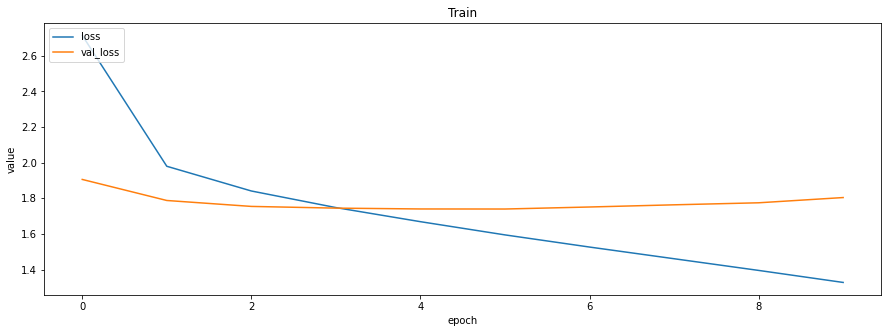

[1.9056648015975952,
 1.787602424621582,
 1.754339337348938,
 1.744746446609497,
 1.7400459051132202,
 1.7397021055221558,
 1.7510631084442139,
 1.7633084058761597,
 1.774664282798767,
 1.8040465116500854]

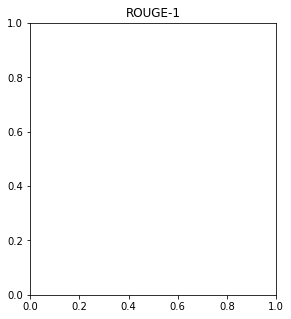

In [ ]:
history_path = "/content/drive/MyDrive/best_weights/T5_stack_history"
plot_all(history_path)
history = json.load(open(history_path, 'r'))
history["val_loss"]

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/T5_stack/saved-model-06"
model_T5.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_stack, model_T5, tok_T5, batch_size = 5, name = "T5")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 33.6486, 'rouge2': 7.5263, 'rougeL': 21.1402, 'rougeLsum': 29.5472}
BERT scores  :   {'precision': 86.3121, 'recall': 86.7971, 'f1': 86.5493}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 29.4899, 'rouge2': 7.6931, 'rougeL': 21.9272, 'rougeLsum': 26.703}
BERT scores  :   {'precision': 87.8509, 'recall': 87.3833, 'f1': 87.6114}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 34.2993, 'rouge2': 10.7254, 'rougeL': 23.8946, 'rougeLsum': 30.0808}
BERT scores  :   {'precision': 86.7403, 'recall': 86.7952, 'f1': 86.7666}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 31.3912, 'rouge2': 6.263, 'rougeL': 21.5129, 'rougeLsum': 27.0144}
BERT scores  :   {'precision': 87.0516, 'recall': 87.4157, 'f1': 87.2309}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE    

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/T5_stack/saved-model-10"
model_T5.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_stack, model_T5, tok_T5, batch_size = 5, name = "T5")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 33.5686, 'rouge2': 8.9272, 'rougeL': 21.7488, 'rougeLsum': 29.6541}
BERT scores  :   {'precision': 86.8944, 'recall': 87.1838, 'f1': 87.0362}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 36.1536, 'rouge2': 9.3551, 'rougeL': 23.7407, 'rougeLsum': 33.1136}
BERT scores  :   {'precision': 88.36, 'recall': 87.9493, 'f1': 88.1474}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 33.9155, 'rouge2': 10.9799, 'rougeL': 24.1084, 'rougeLsum': 31.9034}
BERT scores  :   {'precision': 86.6043, 'recall': 87.3474, 'f1': 86.9719}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 34.5578, 'rouge2': 10.4361, 'rougeL': 22.1095, 'rougeLsum': 30.8157}
BERT scores  :   {'precision': 86.8865, 'recall': 87.7579, 'f1': 87.3177}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE   

In [ ]:
tok = tok_T5
mod = model_T5
tokenized_data = tokenized_stack

inputs = np.squeeze(np.array([tokenized_data["test"]["input_ids"]]))
summas = tokenized_data["test"]["summary"]
gold_summaries = np.squeeze(np.array([tokenized_data["test"]["labels"]]))

for i in range(10,len(inputs)):
  decoded_labels = tok.batch_decode(gold_summaries[i], skip_special_tokens=True)
  print("\nORIGINAL\n")
  print(textwrap.fill(summas[i], 100))
  summary_ids = mod.generate(inputs[i].reshape(1,512), num_beams=4, max_length = 125, min_length = 100)
  decoded_preds = tok.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
  print("\nGENERATED\n")
  print(textwrap.fill(decoded_preds[0], 100))
  print("______________________________________________________________________________________________________")
  if i  == 14:
    break


ORIGINAL

Many commentators give suggestions for a circuit, either to improve his current one or to give him a
new one. Several commentators say that the zeners are backward, but one says that they’re just fine.
One commentator recommends an opamp, and another gives a product link for an AC output.

GENERATED

Commenters suggest using an opamp to make the ground point. One suggests using a power-opamp instead
of a 9V battery to make the ground point. Another suggests using a power-opamp to make the ground
point. One commenter notes that the zeners come with a tolerance of about 5% as the norm. Another
commenter suggests using a circuit simulator to simulate the circuit to simulate the circuit to
create a symmetric output.
______________________________________________________________________________________________________

ORIGINAL

Commentators are nearly unanimous that the Kansas City strip and New York strip are the same meat
cut. A few commentators note that the Kansas City strip

# Full dataset with T5

In [ ]:
convoSum = preprocess_function_step_1(None)
tokenized_convoSum = convoSum.map(preprocess_function_T5_tokenizer, batched=True)
convoSum_train_set, convoSum_val_set, convoSum_test_set, convoSum_generation  = get_tf_dataset_iterator(tokenized_convoSum, batch_sizes = 4)

filepath = "/content/drive/MyDrive/best_weights/T5_convoSum/saved-model-{epoch:02d}"
history_path = "/content/drive/MyDrive/best_weights/T5_convoSum_history"

checkpoint = ModelCheckpoint(filepath,  verbose=1, save_weights_only = True, save_freq='epoch')

metric_callback = KerasMetricCallback(
    metric_fn_T5, eval_dataset=convoSum_generation, predict_with_generate=True
)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
callbacks_list = [ checkpoint]

with tf.device('/GPU:0'):
    history_convoSum = model_T5.fit(x = convoSum_train_set, validation_data = convoSum_val_set, epochs=10, callbacks=callbacks_list) 

json.dump(history_convoSum.history, open(history_path, 'w'))

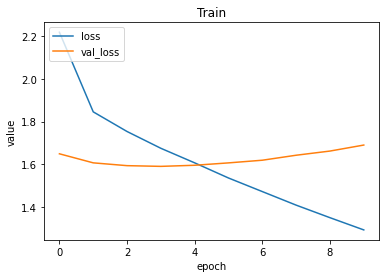

[1.6490401029586792,
 1.606581211090088,
 1.5934289693832397,
 1.5900846719741821,
 1.5952675342559814,
 1.606419324874878,
 1.6189268827438354,
 1.6423321962356567,
 1.6618956327438354,
 1.6900582313537598]

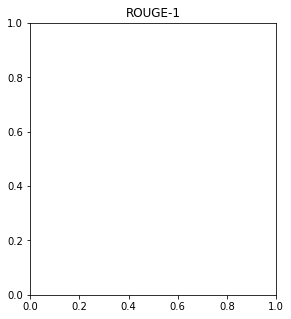

In [ ]:
history_path = "/content/drive/MyDrive/best_weights/T5_convoSum_history"
plot_all(history_path)

In [ ]:
emails = preprocess_function_step_1("email")
tokenized_emails = emails.map(preprocess_function_T5_tokenizer, batched=True)

nyt = preprocess_function_step_1("nyt")
tokenized_nyt = nyt.map(preprocess_function_T5_tokenizer, batched=True)

reddit = preprocess_function_step_1("reddit")
tokenized_reddit = reddit.map(preprocess_function_T5_tokenizer, batched=True)

stack = preprocess_function_step_1("stack")
tokenized_stack = stack.map(preprocess_function_T5_tokenizer, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
filepath = "/content/drive/MyDrive/best_weights/T5_convoSum/saved-model-04"
model_T5.load_weights(filepath)
rouge_a, bert_a = show_metrics_nice(tokenized_emails, model_T5, tok_T5, batch_size = 5, name = "T5")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 34.71, 'rouge2': 11.649, 'rougeL': 22.4816, 'rougeLsum': 31.146}
BERT scores  :   {'precision': 86.2819, 'recall': 86.9727, 'f1': 86.6081}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 34.7522, 'rouge2': 10.8529, 'rougeL': 22.75, 'rougeLsum': 32.4126}
BERT scores  :   {'precision': 84.3361, 'recall': 86.5945, 'f1': 85.4439}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 34.848, 'rouge2': 11.8133, 'rougeL': 25.0564, 'rougeLsum': 31.4584}
BERT scores  :   {'precision': 85.971, 'recall': 86.716, 'f1': 86.3398}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 42.0322, 'rouge2': 15.318, 'rougeL': 27.3104, 'rougeLsum': 38.2698}
BERT scores  :   {'precision': 87.6275, 'recall': 88.114, 'f1': 87.8695}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE        : 

In [ ]:

rouge_a, bert_a = show_metrics_nice(tokenized_nyt, model_T5, tok_T5, batch_size = 5, name = "T5")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 25.3173, 'rouge2': 5.52, 'rougeL': 18.3249, 'rougeLsum': 22.7539}
BERT scores  :   {'precision': 86.4523, 'recall': 86.5864, 'f1': 86.517}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 33.9757, 'rouge2': 9.0928, 'rougeL': 22.5663, 'rougeLsum': 28.795}
BERT scores  :   {'precision': 86.7777, 'recall': 87.1844, 'f1': 86.9753}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 30.3721, 'rouge2': 5.97, 'rougeL': 18.9641, 'rougeLsum': 26.7178}
BERT scores  :   {'precision': 84.9224, 'recall': 85.4647, 'f1': 85.1903}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 26.9067, 'rouge2': 7.1458, 'rougeL': 19.6858, 'rougeLsum': 23.9248}
BERT scores  :   {'precision': 85.5652, 'recall': 86.3885, 'f1': 85.9719}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE        :

In [ ]:

rouge_a, bert_a = show_metrics_nice(tokenized_reddit, model_T5, tok_T5, batch_size = 5, name = "T5")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 26.8025, 'rouge2': 5.7561, 'rougeL': 18.651, 'rougeLsum': 23.1}
BERT scores  :   {'precision': 85.5532, 'recall': 85.8991, 'f1': 85.7236}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 28.032, 'rouge2': 5.3831, 'rougeL': 21.1546, 'rougeLsum': 24.3458}
BERT scores  :   {'precision': 86.603, 'recall': 86.5352, 'f1': 86.5686}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 27.91, 'rouge2': 6.3649, 'rougeL': 20.0089, 'rougeLsum': 25.256}
BERT scores  :   {'precision': 86.4136, 'recall': 87.2536, 'f1': 86.8185}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 25.1264, 'rouge2': 4.3692, 'rougeL': 18.1843, 'rougeLsum': 22.6412}
BERT scores  :   {'precision': 85.2197, 'recall': 87.2862, 'f1': 86.2318}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE        :   

In [ ]:

rouge_a, bert_a = show_metrics_nice(tokenized_stack, model_T5, tok_T5, batch_size = 5, name = "T5")
mean_scores(rouge_a, bert_a)

 CURRENT BATCH IS :  0 5
ROUGE        :   {'rouge1': 34.0544, 'rouge2': 8.6599, 'rougeL': 23.9373, 'rougeLsum': 29.1184}
BERT scores  :   {'precision': 86.5221, 'recall': 86.2611, 'f1': 86.3875}
____________________________________________
 CURRENT BATCH IS :  5 10
ROUGE        :   {'rouge1': 31.0776, 'rouge2': 6.4961, 'rougeL': 22.4375, 'rougeLsum': 25.843}
BERT scores  :   {'precision': 86.7124, 'recall': 86.8672, 'f1': 86.7863}
____________________________________________
 CURRENT BATCH IS :  10 15
ROUGE        :   {'rouge1': 33.6792, 'rouge2': 11.3929, 'rougeL': 24.4497, 'rougeLsum': 29.9358}
BERT scores  :   {'precision': 86.4395, 'recall': 86.7365, 'f1': 86.5735}
____________________________________________
 CURRENT BATCH IS :  15 20
ROUGE        :   {'rouge1': 34.4735, 'rouge2': 10.1414, 'rougeL': 21.9225, 'rougeLsum': 28.0115}
BERT scores  :   {'precision': 86.0254, 'recall': 86.9796, 'f1': 86.4962}
____________________________________________
 CURRENT BATCH IS :  20 25
ROUGE  

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# DATA for histories

In [ ]:
bart_hist = {
    "emails" : {
                    "rouge-1"     : 38.96 ,
                    "rouge-2"     : 12.204,
                    "rouge-L"     : 25.992,
                    "rouge-Lsum"  : 35.349,
                    "f1"          : 87.467,
                    "precision"   : 87.703,
                    "recall"      : 87.248,
        
                },
    "nyt"    : {
                    "rouge-1"     : 35.983,
                    "rouge-2"     : 9.329 ,
                    "rouge-L"     : 22.107,
                    "rouge-Lsum"  : 32.163,
                    "f1"          : 87.825,
                    "precision"   : 88.032,
                    "recall"      : 87.626,
        
                },
    "reddit" : {
                    "rouge-1"     : 35.487,
                    "rouge-2"     : 10.77 ,
                    "rouge-L"     : 22.016,
                    "rouge-Lsum"  : 32.387,
                    "f1"          : 87.766,
                    "precision"   : 87.444,
                    "recall"      : 88.098,
        
                },
    "stack"  : {
                    "rouge-1"     : 39.057,
                    "rouge-2"     : 11.46 ,
                    "rouge-L"     : 23.617,
                    "rouge-Lsum"  : 34.749,
                    "f1"          : 87.919,
                    "precision"   : 87.784,
                    "recall"      : 88.065,
        
                }
   
    
}

bart_convo_hist = {
    "emails" : {
                    "rouge-1"     : 40.013,
                    "rouge-2"     : 12.106,
                    "rouge-L"     : 24.956 ,
                    "rouge-Lsum"  : 36.957,
                    "f1"          : 87.678,
                    "precision"   : 87.474,
                    "recall"      : 87.892,
        
                },
    "nyt"    : {
                    "rouge-1"     : 37.676,
                    "rouge-2"     : 10.43 ,
                    "rouge-L"     : 22.137,
                    "rouge-Lsum"  : 33.931,
                    "f1"          : 88.107,
                    "precision"   : 88.045,
                    "recall"      : 88.177,
        
                },
    "reddit" : {
                    "rouge-1"     : 35.855,
                    "rouge-2"     : 10.172,
                    "rouge-L"     : 22.158,
                    "rouge-Lsum"  : 32.645,
                    "f1"          : 87.837,
                    "precision"   : 87.55 ,
                    "recall"      : 88.136,
        
                },
    "stack"  : {
                    "rouge-1"     : 38.01 ,
                    "rouge-2"     : 11.552,
                    "rouge-L"     : 23.612,
                    "rouge-Lsum"  : 33.906,
                    "f1"          : 87.978,
                    "precision"   : 88.022,
                    "recall"      : 87.942,
        
                }
   
    
}

pegasus_hist = {
    "emails" : {
                    "rouge-1"     : 34.278,
                    "rouge-2"     : 9.515 ,
                    "rouge-L"     : 24.094,
                    "rouge-Lsum"  : 30.9 ,
                    "f1"          : 86.56 ,
                    "precision"   : 86.164,
                    "recall"      : 86.97 ,
        
                },
    "nyt"    : {
                    "rouge-1"     : 24.622,
                    "rouge-2"     : 5.266 ,
                    "rouge-L"     : 18.689,
                    "rouge-Lsum"  : 20.629,
                    "f1"          : 85.347,
                    "precision"   : 84.814,
                    "recall"      : 85.911,
        
                },
    "reddit" : {
                    "rouge-1"     : 25.571,
                    "rouge-2"     : 6.773 ,
                    "rouge-L"     : 19.881,
                    "rouge-Lsum"  : 21.825,
                    "f1"          : 85.813,
                    "precision"   : 85.21 ,
                    "recall"      : 86.444,
        
                },
    "stack"  : {
                    "rouge-1"     : 29.51 ,
                    "rouge-2"     : 7.01  ,
                    "rouge-L"     : 22.122,
                    "rouge-Lsum"  : 24.913,
                    "f1"          : 85.959,
                    "precision"   : 85.446,
                    "recall"      : 86.504,
        
                }

    
}

pegasus_convo_hist = {
    "emails" : {
                    "rouge-1"     : 32.01 ,
                    "rouge-2"     : 9.52  ,
                    "rouge-L"     : 23.255,
                    "rouge-Lsum"  : 28.016,
                    "f1"          : 86.184,
                    "precision"   : 85.836,
                    "recall"      : 86.549,
        
                },
    "nyt"    : {
                    "rouge-1"     : 26.317,
                    "rouge-2"     : 5.715 ,
                    "rouge-L"     : 19.689,
                    "rouge-Lsum"  : 22.095,
                    "f1"          : 85.771,
                    "precision"   : 85.402,
                    "recall"      : 86.153,
        
                },
    "reddit" : {
                    "rouge-1"     : 24.507,
                    "rouge-2"     : 5.955 ,
                    "rouge-L"     : 19.795,
                    "rouge-Lsum"  : 20.698,
                    "f1"          : 85.333,
                    "precision"   : 84.619,
                    "recall"      : 86.082,
        
                },
    "stack"  : {
                    "rouge-1"     : 29.676,
                    "rouge-2"     : 8.205 ,
                    "rouge-L"     : 22.289,
                    "rouge-Lsum"  : 25.429,
                    "f1"          : 86.134,
                    "precision"   : 85.88 ,
                    "recall"      : 86.4  ,
        
                }
   
    
}

t5_hist = {
    "emails" : {
                    "rouge-1"     : 38.921,
                    "rouge-2"     : 12.524,
                    "rouge-L"     : 25.549,
                    "rouge-Lsum"  : 34.808,
                    "f1"          : 87.224,
                    "precision"   : 86.875,
                    "recall"      : 87.585,
        
                },
    "nyt"    : {
                    "rouge-1"     : 31.136,
                    "rouge-2"     : 6.937 ,
                    "rouge-L"     : 20.759,
                    "rouge-Lsum"  : 27.835,
                    "f1"          : 86.808,
                    "precision"   : 86.472,
                    "recall"      : 87.153,
        
                },
    "reddit" : {
                    "rouge-1"     : 31.155,
                    "rouge-2"     : 7.908 ,
                    "rouge-L"     : 21.777,
                    "rouge-Lsum"  : 27.697,
                    "f1"          : 87.022,
                    "precision"   : 86.804,
                    "recall"      : 87.252,
        
                },
    "stack"  : {
                    "rouge-1"     : 34.958,
                    "rouge-2"     : 9.928 ,
                    "rouge-L"     : 22.53 ,
                    "rouge-Lsum"  : 31.117,
                    "f1"          : 87.379,
                    "precision"   : 87.073,
                    "recall"      : 87.7  ,
        
                }
   
}

t5_convo_hist = {
    "emails" : {
                    "rouge-1"     : 36.535,
                    "rouge-2"     : 11.371,
                    "rouge-L"     : 24.683,
                    "rouge-Lsum"  : 33.083,
                    "f1"          : 86.666,
                    "precision"   : 86.15 ,
                    "recall"      : 87.208,
        
                },
    "nyt"    : {
                    "rouge-1"     : 28.193,
                    "rouge-2"     : 6.359 ,
                    "rouge-L"     : 19.771,
                    "rouge-Lsum"  : 24.993,
                    "f1"          : 86.156,
                    "precision"   : 85.953,
                    "recall"      : 86.37 ,
        
                },
    "reddit" : {
                    "rouge-1"     : 27.38 ,
                    "rouge-2"     : 6.209 ,
                    "rouge-L"     : 20.113,
                    "rouge-Lsum"  : 23.934,
                    "f1"          : 86.245,
                    "precision"   : 85.854,
                    "recall"      : 86.657,
        
                },
    "stack"  : {
                    "rouge-1"     : 33.225,
                    "rouge-2"     : 9.782 ,
                    "rouge-L"     : 23.49 ,
                    "rouge-Lsum"  : 28.179,
                    "f1"          : 86.698,
                    "precision"   : 86.583,
                    "recall"      : 86.832,
        
                }
   
    
}

# PLOTS OF TOKEN INFO AND HISTORIES

In [ ]:
emails = preprocess_function_step_1("email")
tokenized_emails = emails.map(preprocess_function_BART_tokenizer_SHOW_TOKENS_LENS, batched=True)

nyt = preprocess_function_step_1("nyt")
tokenized_nyt = nyt.map(preprocess_function_BART_tokenizer_SHOW_TOKENS_LENS, batched=True)

reddit = preprocess_function_step_1("reddit")
tokenized_reddit = reddit.map(preprocess_function_BART_tokenizer_SHOW_TOKENS_LENS, batched=True)

stack = preprocess_function_step_1("stack")
tokenized_stack = stack.map(preprocess_function_BART_tokenizer_SHOW_TOKENS_LENS, batched=True)

cat = "input_ids"
lens_train_emails = [len(el) for el in tokenized_emails["train"][cat]]
lens_val_emails = [len(el) for el in tokenized_emails["validation"][cat]]
lens_test_emails = [len(el) for el in tokenized_emails["test"][cat]]

lens_train_nyt = [len(el) for el in tokenized_nyt["train"][cat]]
lens_val_nyt = [len(el) for el in tokenized_nyt["validation"][cat]]
lens_test_nyt = [len(el) for el in tokenized_nyt["test"][cat]]

lens_train_reddit = [len(el) for el in tokenized_reddit["train"][cat]]
lens_val_reddit = [len(el) for el in tokenized_reddit["validation"][cat]]
lens_test_reddit = [len(el) for el in tokenized_reddit["test"][cat]]

lens_train_stack = [len(el) for el in tokenized_stack["train"][cat]]
lens_val_stack = [len(el) for el in tokenized_stack["validation"][cat]]
lens_test_stack = [len(el) for el in tokenized_stack["test"][cat]]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

1307


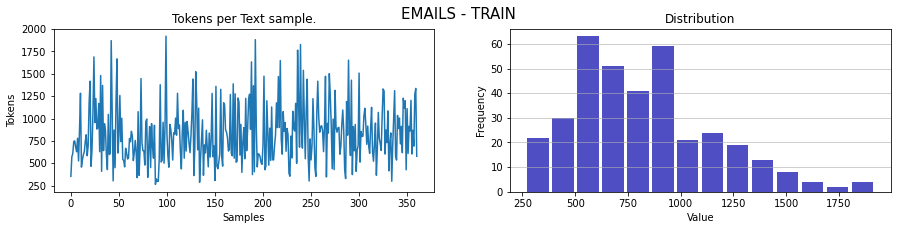

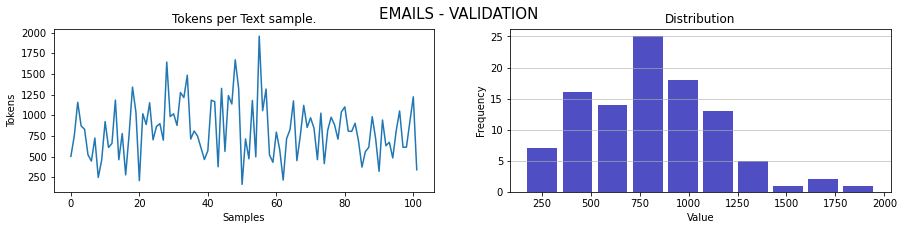

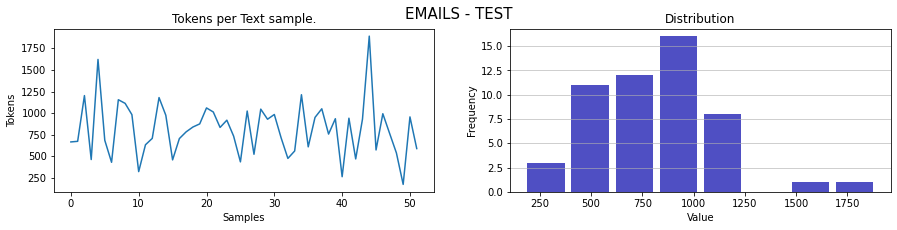

In [ ]:
print(len(tokenized_emails["train"]["text"][0]))
#print(tokenized_emails["train"]["text"][0])
plot_distribution(lens_train_emails, "EMAILS - TRAIN", params = (15, 3))
plot_distribution(lens_val_emails, "EMAILS - VALIDATION", params = (15, 3))
plot_distribution(lens_test_emails, "EMAILS - TEST", params = (15, 3))

5674


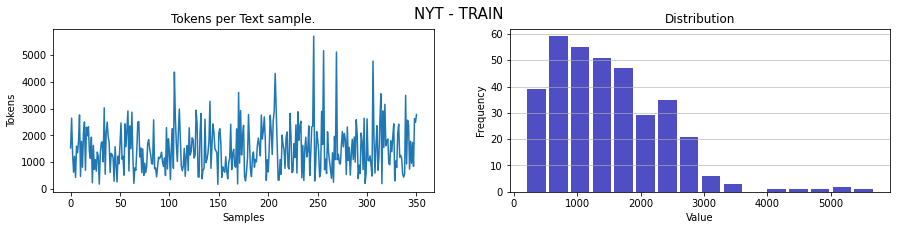

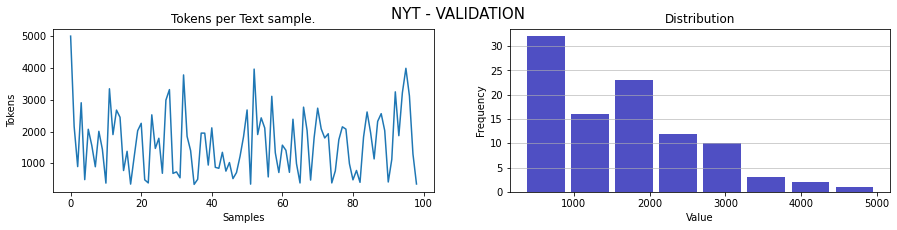

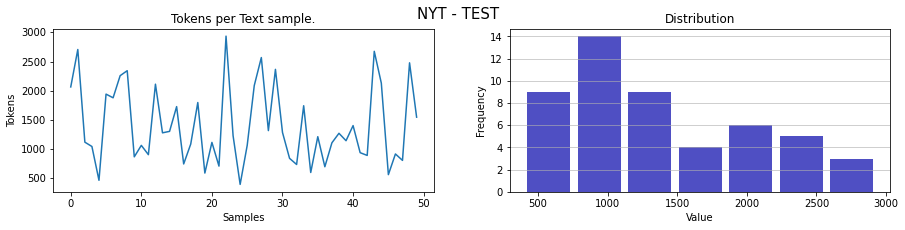

In [ ]:
print(len(tokenized_nyt["train"]["text"][0]))
#print(tokenized_nyt["train"]["text"][0])

plot_distribution(lens_train_nyt , "NYT - TRAIN", params = (15, 3))
plot_distribution(lens_val_nyt , "NYT - VALIDATION", params = (15, 3))
plot_distribution(lens_test_nyt , "NYT - TEST", params = (15, 3))

528


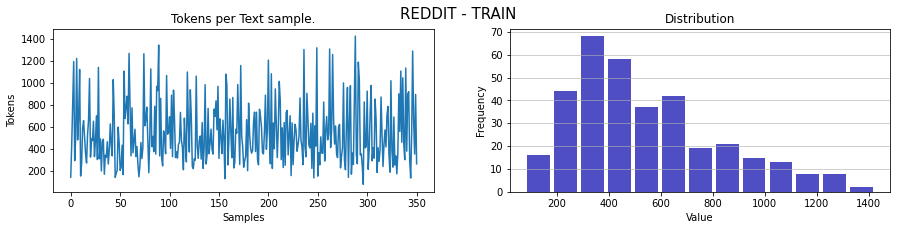

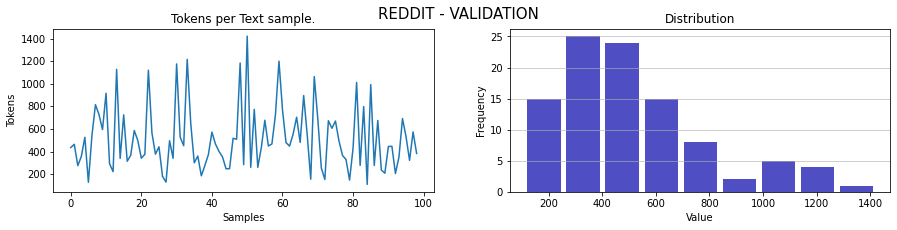

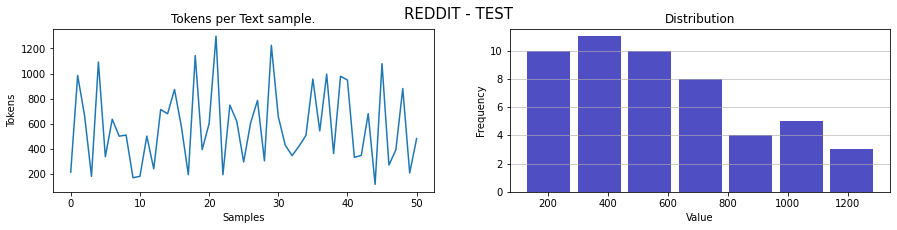

In [ ]:
print(len(tokenized_reddit["train"]["text"][0]))
#print(tokenized_reddit["train"]["text"][0])

plot_distribution(lens_train_reddit, "REDDIT - TRAIN", params = (15, 3))
plot_distribution(lens_val_reddit, "REDDIT - VALIDATION", params = (15, 3))
plot_distribution(lens_test_reddit, "REDDIT - TEST", params = (15, 3))

3136


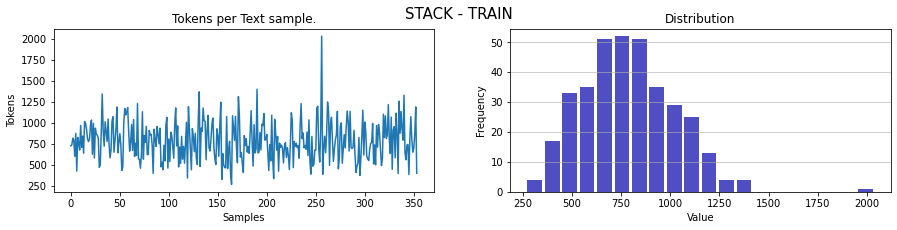

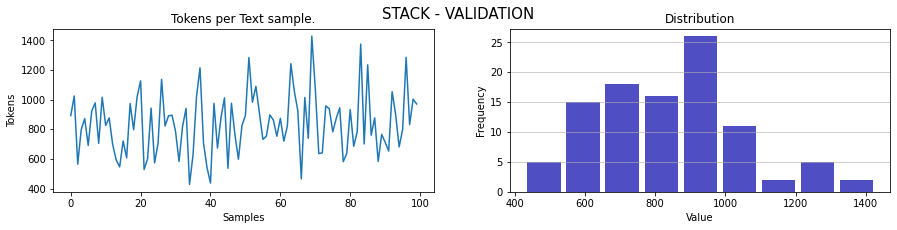

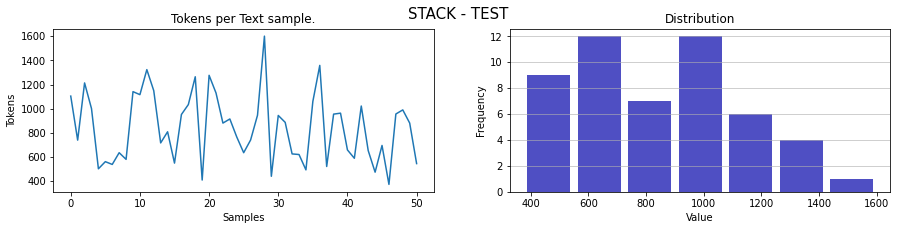

In [ ]:
print(len(tokenized_stack["train"]["text"][0]))
#print(tokenized_stack["train"]["text"][0])

plot_distribution(lens_train_stack, "STACK - TRAIN", params = (15, 3))
plot_distribution(lens_val_stack, "STACK - VALIDATION", params = (15, 3))
plot_distribution(lens_test_stack , "STACK - TEST", params = (15, 3))

In [ ]:
#['loss', "val_loss", 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'gen_len']:


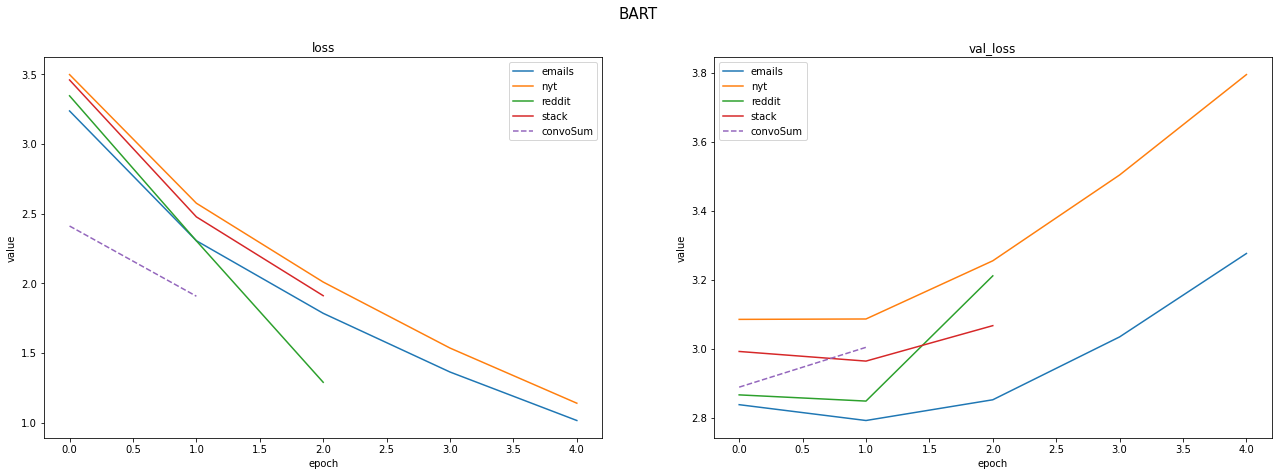

In [ ]:
print_plots(model_name = "BART", metrics = ['loss', "val_loss"], params = (22,7))

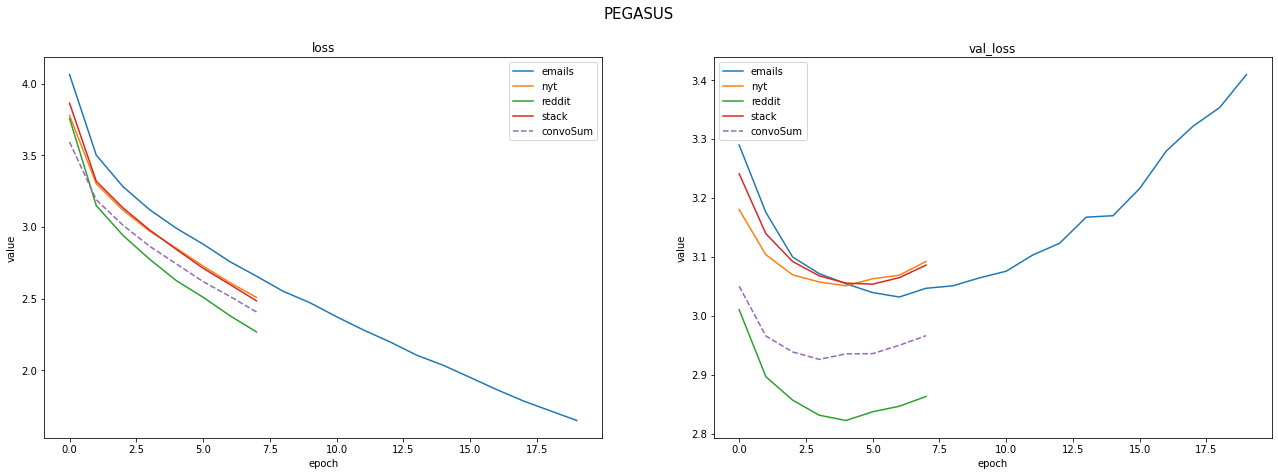

In [ ]:
print_plots(model_name = "PEGASUS", metrics = ['loss', "val_loss"], params = (22,7))

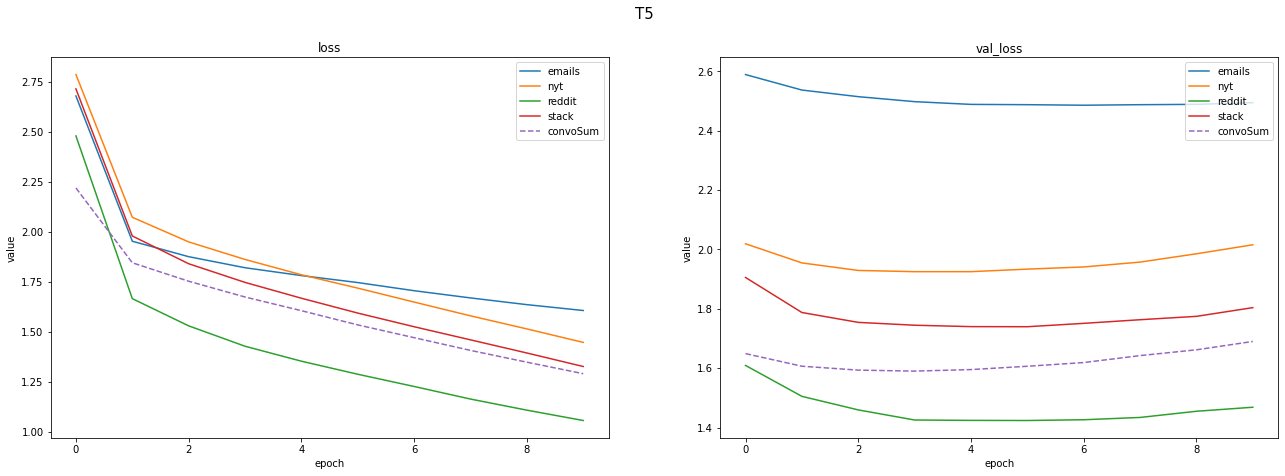

In [ ]:
print_plots(model_name = "T5", metrics = ['loss', "val_loss"], params = (22,7))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


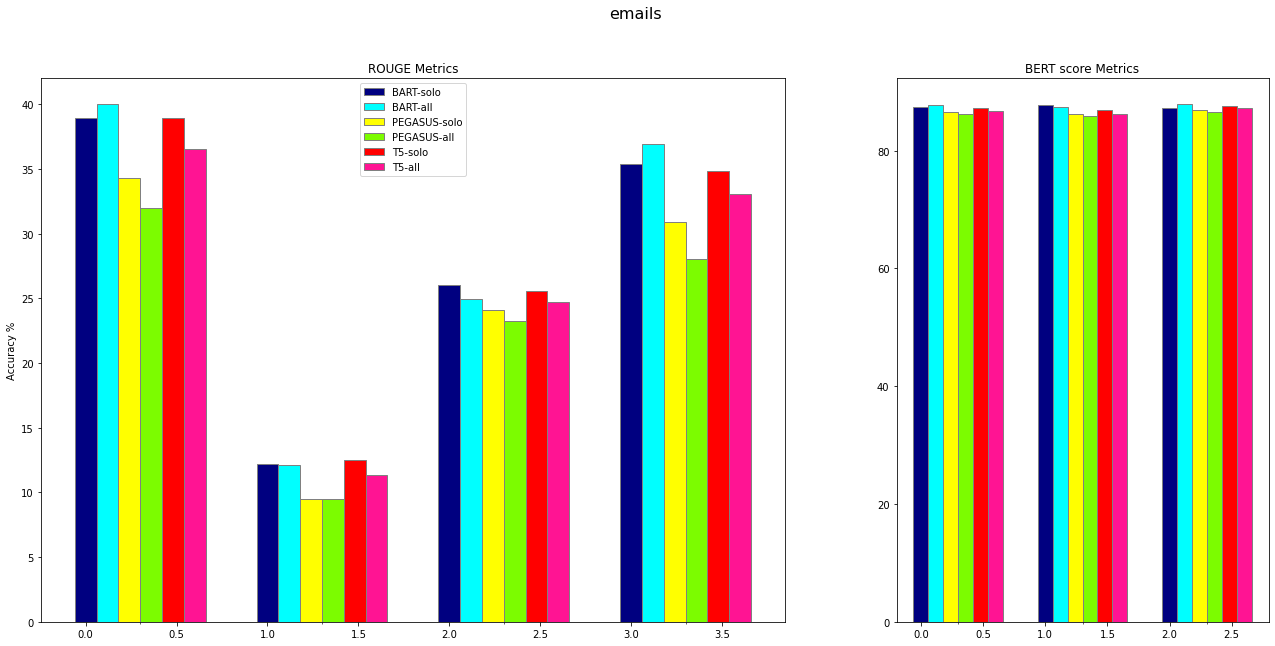

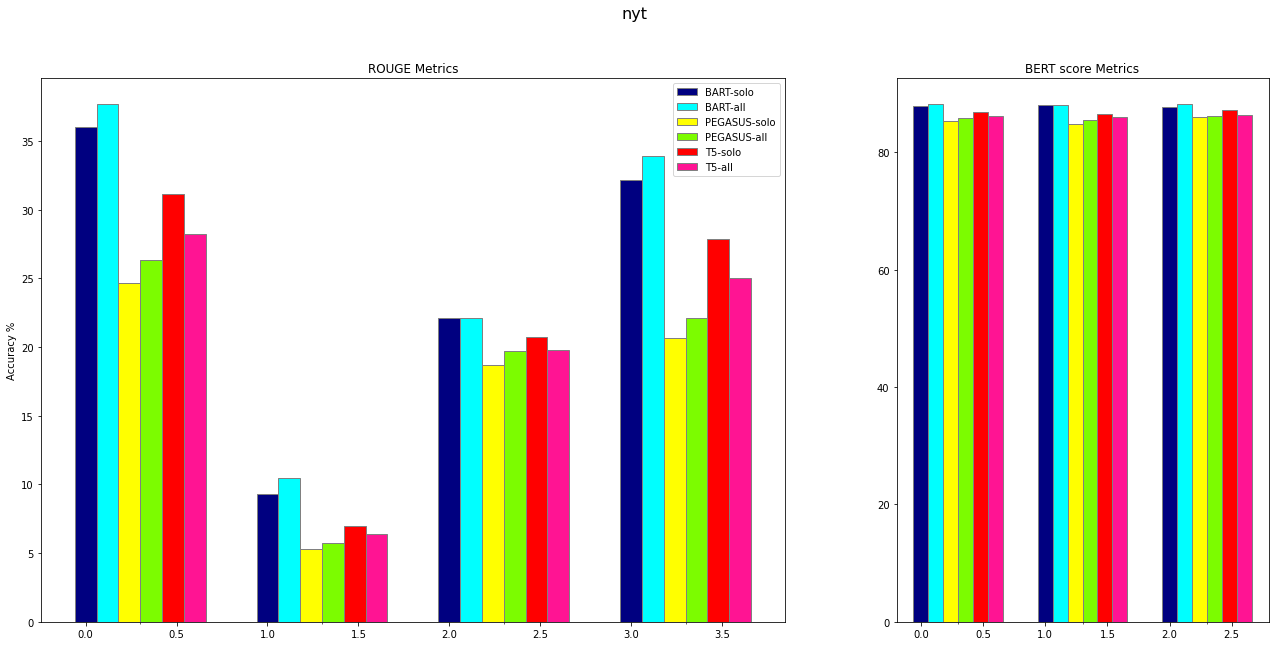

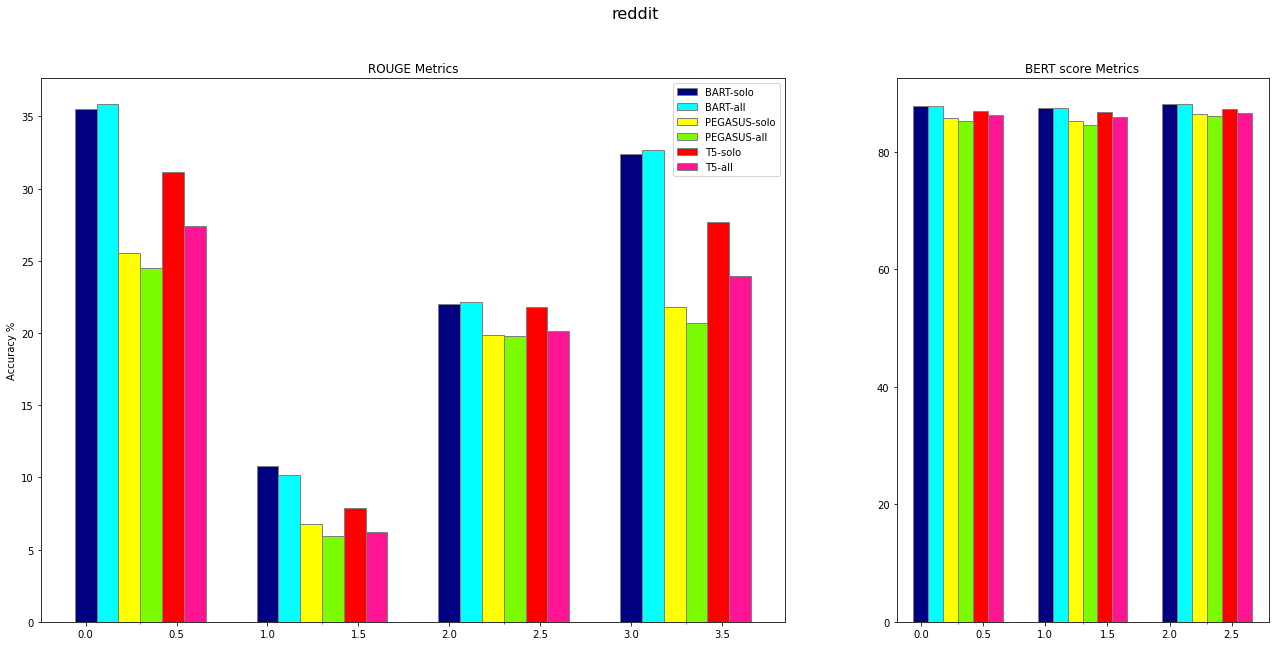

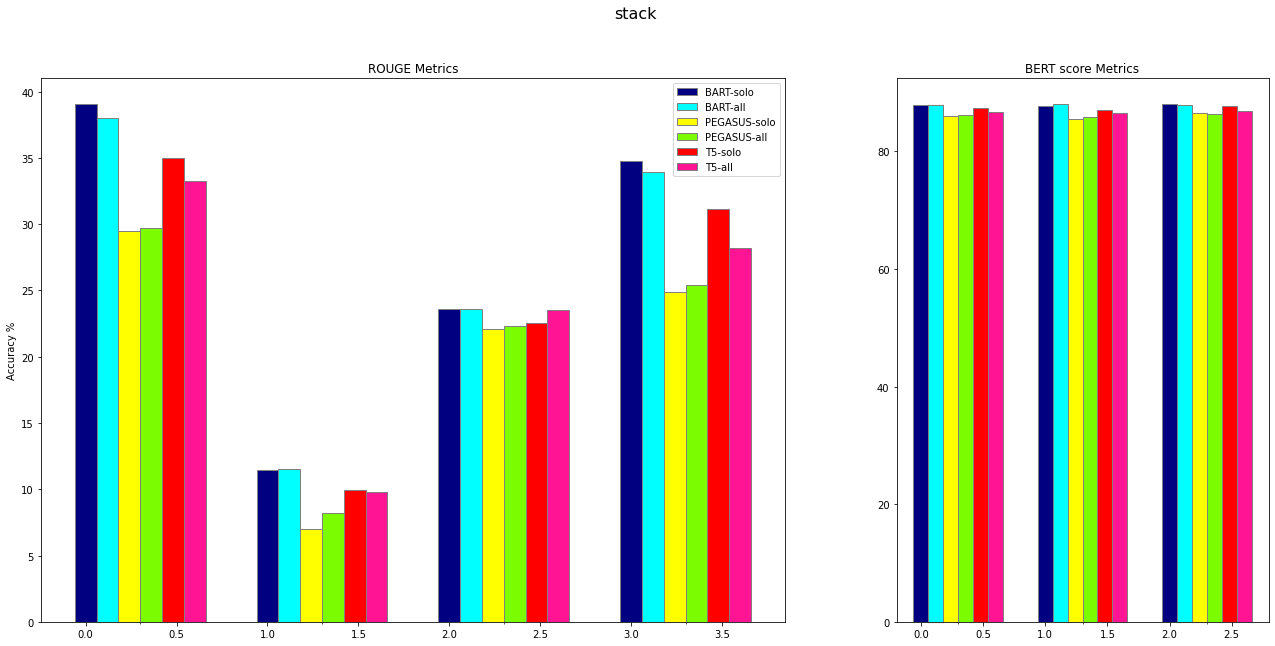

In [ ]:
for part in bart_hist.keys():
    
    barWidth = 0.12
    
    plt.rcParams["figure.figsize"] = (22,10)
    
    
    f, (plt0, plt1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [6, 3]}, )
 
     
    l1 = list(bart_hist[part].values())[:-3]
    l2 = list(bart_convo_hist[part].values())[:-3]
    l3 = list(pegasus_hist[part].values())[:-3]
    l4 = list(pegasus_convo_hist[part].values())[:-3]
    l5 = list(t5_hist[part].values())[:-3]
    l6 = list(t5_convo_hist[part].values())[:-3]
    
    br1 = np.arange(len(l1))
    br1_1 = [x + barWidth  for x in br1]
    br2 = [x + barWidth for x in br1_1]
    br2_2 = [x + barWidth for x in br2]
    br3 = [x + barWidth for x in br2_2]
    br3_3 = [x + barWidth for x in br3]
    
    # creating the bar plot
    plt0.bar(br1, l1, color ='navy', width = barWidth,
        edgecolor ='grey', label ='BART-solo')
    plt0.bar(br1_1, l2, color ='aqua', width = barWidth,
        edgecolor ='grey', label ='BART-all')
    
    plt0.bar(br2, l3, color ='yellow', width = barWidth,
            edgecolor ='grey', label ='PEGASUS-solo')
    plt0.bar(br2_2, l4, color ='lawngreen', width = barWidth,
            edgecolor ='grey', label ='PEGASUS-all')
    
    plt0.bar(br3, l5, color ='red', width = barWidth,
            edgecolor ='grey', label ='T5-solo')
    plt0.bar(br3_3, l6, color ='deeppink', width = barWidth,
            edgecolor ='grey', label ='T5-all')
    
    plt0.set_title("ROUGE Metrics")
    #plt.xlabel("Metrics")
    plt0.set_ylabel("Accuracy %")
    #plt0.ylabel("Accuracy %")
    
    
    plt0.set_xticks([r + barWidth +0.18 for r in range(len(l1))],
        list(t5_hist[part].keys())[:-3])
    
    plt0.legend()
    
    
    l1 = list(bart_hist[part].values())[-3:]
    l2 = list(bart_convo_hist[part].values())[-3:]
    l3 = list(pegasus_hist[part].values())[-3:]
    l4 = list(pegasus_convo_hist[part].values())[-3:]
    l5 = list(t5_hist[part].values())[-3:]
    l6 = list(t5_convo_hist[part].values())[-3:]
    
    br1 = np.arange(len(l1))
    br1_1 = [x + barWidth for x in br1]
    br2 = [x + barWidth for x in br1_1]
    br2_2 = [x + barWidth for x in br2]
    br3 = [x + barWidth for x in br2_2]
    br3_3 = [x + barWidth for x in br3]
    
    
    plt1.bar(br1, l1, color ='navy', width = barWidth,
        edgecolor ='grey', label ='BART-solo')
    plt1.bar(br1_1, l2, color ='aqua', width = barWidth,
        edgecolor ='grey', label ='BART-all')
    
    plt1.bar(br2, l3, color ='yellow', width = barWidth,
            edgecolor ='grey', label ='PEGASUS-solo')
    plt1.bar(br2_2, l4, color ='lawngreen', width = barWidth,
            edgecolor ='grey', label ='PEGASUS-all')
    
    plt1.bar(br3, l5, color ='red', width = barWidth,
            edgecolor ='grey', label ='T5-solo')
    plt1.bar(br3_3, l6, color ='deeppink', width = barWidth,
            edgecolor ='grey', label ='T5-all')
    
    plt1.set_title("BERT score Metrics")
    #plt1.set_ylabel("Accuracy %")
    
    plt1.set_xticks([r + barWidth +0.18 for r in range(len(l1))],
        list(t5_hist[part].keys())[-3:])
    
    f.suptitle(part, fontsize=16)

    plt.show()


